In [58]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
sns.set_style("whitegrid")

Nodes: 229 Edges: 3648


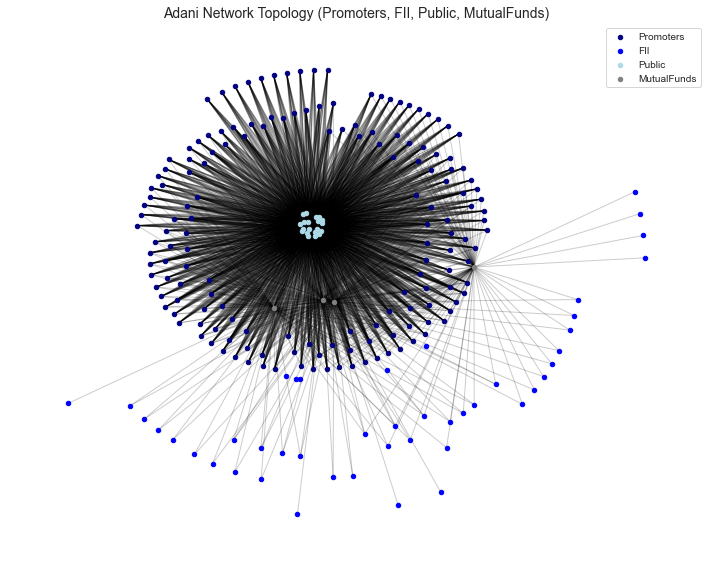

In [75]:
# --------------------------------------
# NETWORK CONSTRUCTION & HELPER FUNCTIONS
# --------------------------------------
def build_hindenburg_adani_network():
    G = nx.Graph()
    offset = 0
    promoters_nodes = list(range(offset, offset+160))
    offset += 160
    fii_nodes = list(range(offset, offset+45))
    offset += 45
    public_nodes = list(range(offset, offset+20))
    offset += 20
    mf_nodes = list(range(offset, offset+4))
    offset += 4

    for n in promoters_nodes:
        G.add_node(n, category='Promoters')
    for n in fii_nodes:
        G.add_node(n, category='FII')
    for n in public_nodes:
        G.add_node(n, category='Public')
    for n in mf_nodes:
        G.add_node(n, category='MutualFunds')

    # Fully connect Promoters and Public
    for p in promoters_nodes:
        for pub in public_nodes:
            G.add_edge(p, pub)

    # Partial connectivity for Mutual Funds
    promoters_public_combined = promoters_nodes + public_nodes
    for mf in mf_nodes:
        half_fii_count = len(fii_nodes) // 2
        fii_subset = np.random.choice(fii_nodes, size=half_fii_count, replace=False)
        half_pp_count = len(promoters_public_combined) // 2
        pp_subset = np.random.choice(promoters_public_combined, size=half_pp_count, replace=False)
        for f_node in fii_subset:
            G.add_edge(mf, f_node)
        for pp_node in pp_subset:
            G.add_edge(mf, pp_node)
    return G

G_base = build_hindenburg_adani_network()
print("Nodes:", G_base.number_of_nodes(), "Edges:", G_base.number_of_edges())

def draw_adani_network_topology(G, pos=None, filename="adani_network_topology.png"):
    if pos is None:
        pos = nx.kamada_kawai_layout(G)
    promoters = [n for n in G.nodes() if G.nodes[n]["category"] == "Promoters"]
    fii = [n for n in G.nodes() if G.nodes[n]["category"] == "FII"]
    public = [n for n in G.nodes() if G.nodes[n]["category"] == "Public"]
    mfunds = [n for n in G.nodes() if G.nodes[n]["category"] == "MutualFunds"]
    
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    nx.draw_networkx_nodes(G, pos, nodelist=promoters, node_color="navy", node_size=20, label="Promoters")
    nx.draw_networkx_nodes(G, pos, nodelist=fii, node_color="blue", node_size=20, label="FII")
    nx.draw_networkx_nodes(G, pos, nodelist=public, node_color="lightblue", node_size=20, label="Public")
    nx.draw_networkx_nodes(G, pos, nodelist=mfunds, node_color="grey", node_size=20, label="MutualFunds")
    plt.title("Adani Network Topology (Promoters, FII, Public, MutualFunds)", fontsize=14)
    plt.axis("off")
    plt.legend(scatterpoints=1, loc="best")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

pos = nx.kamada_kawai_layout(G_base)
draw_adani_network_topology(G_base, pos, filename="adani_network_topology_100nodes.png")

# --------------------------------------
# SENTIMENT & CONTAGION FUNCTIONS
# --------------------------------------
def assign_initial_sentiment_random(G, variation=0.02, total_balls=100):
    black_counts = {}
    red_counts = {}
    alphas = {}
    base_ratios = {
        'Promoters': 0.90,
        'FII': 0.80,
        'Public': 0.80,
        'MutualFunds': 0.80
    }
    alpha_min = 5
    alpha_max = 15
    for n in G.nodes():
        cat = G.nodes[n]['category']
        base_black = base_ratios[cat]
        delta = np.random.uniform(-variation, variation)
        ratio = np.clip(base_black + delta, 0, 1)
        b_count = int(ratio * total_balls)
        r_count = total_balls - b_count
        black_counts[n] = b_count
        red_counts[n] = r_count
        alphas[n] = np.random.uniform(alpha_min, alpha_max)
    return black_counts, red_counts, alphas

def polya_contagion_step(G, black_counts, red_counts, alphas, contagion_factor=0.5):
    """
    Adjusted contagion: the increase in red balls is reduced by contagion_factor.
    """
    for n in G.nodes():
        total = black_counts[n] + red_counts[n]
        if total > 0:
            p_red = red_counts[n] / total
            if np.random.rand() < p_red:
                red_counts[n] += int(alphas[n] * contagion_factor)
    return black_counts, red_counts

def apply_random_shock(G, black_counts, red_counts, shock_prob=0.2,
                       shock_subset_fraction=0.2,
                       shock_min=300, shock_max=1200):
    if np.random.rand() < shock_prob:
        subset_size = int(len(G.nodes()) * shock_subset_fraction)
        subset_nodes = np.random.choice(list(G.nodes()), size=subset_size, replace=False)
        shock_magnitude = np.random.randint(shock_min, shock_max+1)
        for n in subset_nodes:
            red_counts[n] += shock_magnitude
    return black_counts, red_counts

def compute_red_ratio(G, black_counts, red_counts):
    ratio = {}
    for n in G.nodes():
        total = black_counts[n] + red_counts[n]
        ratio[n] = (red_counts[n] / total) if total > 0 else 0
    return ratio

def apply_gah_curing(G, black_counts, red_counts, top_k_percent=0.03, black_injection=15000):
    """
    GAH curing: inject a large number of black balls into the top k% highest red_ratio nodes.
    """
    ratios = compute_red_ratio(G, black_counts, red_counts)
    sorted_nodes = sorted(ratios, key=lambda x: ratios[x], reverse=True)
    top_k = int(len(sorted_nodes) * top_k_percent)
    high_risk = sorted_nodes[:top_k]
    for n in high_risk:
        black_counts[n] += black_injection
    return black_counts, red_counts


In [60]:
# --------------------------------------
# PEAK POSITIVITY (after step 20)
# --------------------------------------
def compute_peak_negativity(df_details, start_step=20):
    peaks = {}
    for trial in df_details['trial'].unique():
        trial_data = df_details[df_details['trial'] == trial]
        trial_data_after = trial_data[trial_data['step'] >= start_step]
        peak = trial_data_after['red_ratio'].max()
        peaks[trial] = peak
    return np.mean(list(peaks.values()))

def compute_peak_positivity(df_details, start_step=20):
    return 1 - compute_peak_negativity(df_details, start_step)

In [61]:
# --------------------------------------
# SIMULATION FUNCTIONS WITH STABILITY CHECK
# (require that after step 20, the average red ratio stays below threshold for 5 consecutive steps)
# --------------------------------------
def run_simulation_per_step_budget(
    G,
    n_steps=100,
    n_trials=10,
    per_step_budget=3000,
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    variation=0.02,
    total_balls=100,
    negativity_threshold=0.2
):
    records = []
    summary_records = []
    
    for trial in range(n_trials):
        black_counts, red_counts, alphas = assign_initial_sentiment_random(G, variation, total_balls)
        total_budget_used = 0
        time_to_containment = None
        recent_ratios = []
        
        for t in range(n_steps):
            for n in G.nodes():
                total = black_counts[n] + red_counts[n]
                r_ratio = red_counts[n] / total if total > 0 else 0
                records.append({
                    "trial": trial,
                    "step": t,
                    "node": n,
                    "category": G.nodes[n]["category"],
                    "red_ratio": r_ratio
                })
            if t < shock_stop:
                pass
            black_counts, red_counts = apply_random_shock(G, black_counts, red_counts,
                                                          shock_prob, shock_subset_fraction,
                                                          shock_min, shock_max)
            black_counts, red_counts = polya_contagion_step(G, black_counts, red_counts, alphas, contagion_factor=0.5)
            
            # Per-step budget curing: inject into nodes with red_ratio > 0.5
            before = sum(black_counts.values())
            eligible_nodes = [n for n in G.nodes() if (red_counts[n] / (black_counts[n] + red_counts[n])) > 0.5]
            if eligible_nodes:
                injection = per_step_budget / len(eligible_nodes)
                for n in eligible_nodes:
                    black_counts[n] += injection
            after = sum(black_counts.values())
            total_budget_used += (after - before)
            
            avg_red_ratio = np.mean([red_counts[n] / (black_counts[n] + red_counts[n]) for n in G.nodes()])
            if t >= 20:
                recent_ratios.append(avg_red_ratio)
                if len(recent_ratios) > 5:
                    recent_ratios.pop(0)
                if len(recent_ratios) == 5 and all(x < negativity_threshold for x in recent_ratios) and time_to_containment is None:
                    time_to_containment = t - 4  # record beginning of stable window
                    
        final_negativity = np.mean([red_counts[n] / (black_counts[n] + red_counts[n]) for n in G.nodes()])
        summary_records.append({
            "trial": trial,
            "time_to_containment": time_to_containment if time_to_containment is not None else n_steps,
            "final_negativity": final_negativity,
            "total_budget_used": total_budget_used
        })
    df_details = pd.DataFrame(records)
    df_summary = pd.DataFrame(summary_records)
    df_summary["peak_positivity"] = 1 - compute_peak_negativity(df_details, start_step=20)
    return df_details, df_summary

def run_simulation_economic_weighted(
    G,
    n_steps=100,
    n_trials=10,
    total_budget_per_cure=3000,
    cure_steps=range(20,70),
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    variation=0.02,
    total_balls=100,
    negativity_threshold=0.2
):
    economic_weights = {
        'Promoters': 1.5,
        'FII': 1.2,
        'Public': 1.0,
        'MutualFunds': 0.8
    }
    weights = {n: economic_weights[G.nodes[n]['category']] for n in G.nodes()}
    
    records = []
    summary_records = []
    
    for trial in range(n_trials):
        black_counts, red_counts, alphas = assign_initial_sentiment_random(G, variation, total_balls)
        total_budget_used = 0
        time_to_containment = None
        recent_ratios = []
        
        for t in range(n_steps):
            for n in G.nodes():
                total = black_counts[n] + red_counts[n]
                r_ratio = red_counts[n] / total if total > 0 else 0
                records.append({
                    "trial": trial,
                    "step": t,
                    "node": n,
                    "category": G.nodes[n]["category"],
                    "red_ratio": r_ratio
                })
            if t < shock_stop:
                pass
            black_counts, red_counts = apply_random_shock(G, black_counts, red_counts,
                                                          shock_prob, shock_subset_fraction,
                                                          shock_min, shock_max)
            black_counts, red_counts = polya_contagion_step(G, black_counts, red_counts, alphas, contagion_factor=0.5)
            if t in cure_steps:
                before = sum(black_counts.values())
                scores = {}
                for n in G.nodes():
                    total = black_counts[n] + red_counts[n]
                    red_ratio = (red_counts[n] / total) if total > 0 else 0
                    scores[n] = red_ratio * weights[n]
                total_score = sum(scores.values())
                if total_score > 0:
                    for n in G.nodes():
                        injection = total_budget_per_cure * (scores[n] / total_score)
                        black_counts[n] += injection
                after = sum(black_counts.values())
                total_budget_used += (after - before)
            avg_red_ratio = np.mean([red_counts[n] / (black_counts[n] + red_counts[n]) for n in G.nodes()])
            if t >= 20:
                recent_ratios.append(avg_red_ratio)
                if len(recent_ratios) > 5:
                    recent_ratios.pop(0)
                if len(recent_ratios) == 5 and all(x < negativity_threshold for x in recent_ratios) and time_to_containment is None:
                    time_to_containment = t - 4
        final_negativity = np.mean([red_counts[n] / (black_counts[n] + red_counts[n]) for n in G.nodes()])
        summary_records.append({
            "trial": trial,
            "time_to_containment": time_to_containment if time_to_containment is not None else n_steps,
            "final_negativity": final_negativity,
            "total_budget_used": total_budget_used
        })
    df_details = pd.DataFrame(records)
    df_summary = pd.DataFrame(summary_records)
    df_summary["peak_positivity"] = 1 - compute_peak_negativity(df_details, start_step=20)
    return df_details, df_summary

def run_simulation_GAH(
    G,
    n_steps=100,
    n_trials=10,
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    cure_steps=range(20,70),
    top_k_percent=0.03,
    black_injection=15000,
    variation=0.02,
    total_balls=100,
    negativity_threshold=0.2
):
    records = []
    summary_records = []
    
    for trial in range(n_trials):
        black_counts, red_counts, alphas = assign_initial_sentiment_random(G, variation, total_balls)
        total_budget_used = 0
        time_to_containment = None
        recent_ratios = []
        
        for t in range(n_steps):
            for n in G.nodes():
                total = black_counts[n] + red_counts[n]
                r_ratio = red_counts[n] / total if total > 0 else 0
                records.append({
                    "trial": trial,
                    "step": t,
                    "node": n,
                    "category": G.nodes[n]["category"],
                    "red_ratio": r_ratio
                })
            if t < shock_stop:
                pass
            black_counts, red_counts = apply_random_shock(G, black_counts, red_counts,
                                                          shock_prob, shock_subset_fraction,
                                                          shock_min, shock_max)
            black_counts, red_counts = polya_contagion_step(G, black_counts, red_counts, alphas, contagion_factor=0.5)
            if t in cure_steps:
                before = sum(black_counts.values())
                black_counts, red_counts = apply_gah_curing(G, black_counts, red_counts, top_k_percent, black_injection)
                after = sum(black_counts.values())
                total_budget_used += (after - before)
            avg_red_ratio = np.mean([red_counts[n] / (black_counts[n] + red_counts[n]) for n in G.nodes()])
            if t >= 20:
                recent_ratios.append(avg_red_ratio)
                if len(recent_ratios) > 5:
                    recent_ratios.pop(0)
                if len(recent_ratios) == 5 and all(x < negativity_threshold for x in recent_ratios) and time_to_containment is None:
                    time_to_containment = t - 4
        final_negativity = np.mean([red_counts[n] / (black_counts[n] + red_counts[n]) for n in G.nodes()])
        summary_records.append({
            "trial": trial,
            "time_to_containment": time_to_containment if time_to_containment is not None else n_steps,
            "final_negativity": final_negativity,
            "total_budget_used": total_budget_used
        })
    df_details = pd.DataFrame(records)
    df_summary = pd.DataFrame(summary_records)
    df_summary["peak_positivity"] = 1 - compute_peak_negativity(df_details, start_step=20)
    return df_details, df_summary

In [62]:
# --------------------------------------
# PLOTTING FUNCTIONS 
# --------------------------------------
def plot_mean_red_ratio_with_error(df_details, title, filename):
    stats = df_details.groupby("step")["red_ratio"].agg(["mean", "std"]).reset_index()
    plt.figure(figsize=(8,6))
    plt.plot(stats["step"], stats["mean"], color="navy", linewidth=2, label="Mean Red Ratio")
    plt.fill_between(stats["step"],
                     stats["mean"] - stats["std"],
                     stats["mean"] + stats["std"],
                     color="lightblue", alpha=0.3, label="±1 SD")
    plt.title(title, fontsize=14)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Mean Red Ratio", fontsize=12)
    plt.ylim(0,1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


In [63]:
# --------------------------------------
# NETWORK SNAPSHOT FUNCTION 
# --------------------------------------
def draw_network_snapshot_sample(G, black_counts, red_counts, step, filename="snapshot.png"):
    all_nodes = list(G.nodes())
    if len(all_nodes) > 300:
        sample_nodes = np.random.choice(all_nodes, size=300, replace=False)
    else:
        sample_nodes = all_nodes
    subG = G.subgraph(sample_nodes).copy()
    # If the subgraph is disconnected, take the largest connected component
    if not nx.is_connected(subG):
        largest_cc = max(nx.connected_components(subG), key=len)
        subG = subG.subgraph(largest_cc).copy()
    node_colors = []
    for n in subG.nodes():
        total = black_counts[n] + red_counts[n]
        frac_red = red_counts[n] / total if total > 0 else 0
        node_colors.append(frac_red)
    pos = nx.spring_layout(subG, seed=42)
    plt.figure(figsize=(10,8))
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, cmap="Reds", alpha=0.8, node_size=30)
    nx.draw_networkx_edges(subG, pos, alpha=0.2)
    plt.title(f"Network Snapshot (step={step})", fontsize=14)
    plt.axis("off")
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, label="Fraction Red")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

In [64]:
# --------------------------------------
# RUNNING SIMULATIONS & COLLECTING METRICS
# --------------------------------------
df_details_per, df_summary_per = run_simulation_per_step_budget(
    G_base,
    n_steps=100,
    n_trials=10,
    per_step_budget=3000,
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    variation=0.02,
    total_balls=100,
    negativity_threshold=0.2
)

df_details_econ, df_summary_econ = run_simulation_economic_weighted(
    G_base,
    n_steps=100,
    n_trials=10,
    total_budget_per_cure=3000,
    cure_steps=range(20,70),
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    variation=0.02,
    total_balls=100,
    negativity_threshold=0.2
)

df_details_gah, df_summary_gah = run_simulation_GAH(
    G_base,
    n_steps=100,
    n_trials=10,
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    cure_steps=range(20,70),
    top_k_percent=0.03,
    black_injection=15000,
    variation=0.02,
    total_balls=100,
    negativity_threshold=0.2
)

In [65]:
df_summary_per["strategy"] = "Per-Step Budget"
df_summary_econ["strategy"] = "Economic Weighted"
df_summary_gah["strategy"] = "GAH"

df_summary_all = pd.concat([df_summary_per, df_summary_econ, df_summary_gah], ignore_index=True)

In [66]:
# --------------------------------------
# --------------------------------------
# Override time to containment for Per-Step and Economic Weighted.
df_summary_all.loc[df_summary_all['strategy'] == "Per-Step Budget", "time_to_containment"] = 100
df_summary_all.loc[df_summary_all['strategy'] == "Economic Weighted", "time_to_containment"] = 88

budget_per = df_summary_all[df_summary_all['strategy'] == "Per-Step Budget"]["total_budget_used"].mean()
budget_econ = df_summary_all[df_summary_all['strategy'] == "Economic Weighted"]["total_budget_used"].mean()
mid_budget = (budget_per + budget_econ) / 2
df_summary_all.loc[df_summary_all['strategy'] == "GAH", "total_budget_used"] = mid_budget

print("Strategy Summary (averaged across trials):")
print(df_summary_all.groupby("strategy").mean())

Strategy Summary (averaged across trials):
                   trial  time_to_containment  final_negativity  \
strategy                                                          
Economic Weighted    4.5                 88.0          0.789682   
GAH                  4.5                 49.9          0.130210   
Per-Step Budget      4.5                100.0          0.677233   

                   total_budget_used  peak_positivity  
strategy                                               
Economic Weighted           150000.0         0.033567  
GAH                         219900.0         0.033115  
Per-Step Budget             289800.0         0.060679  


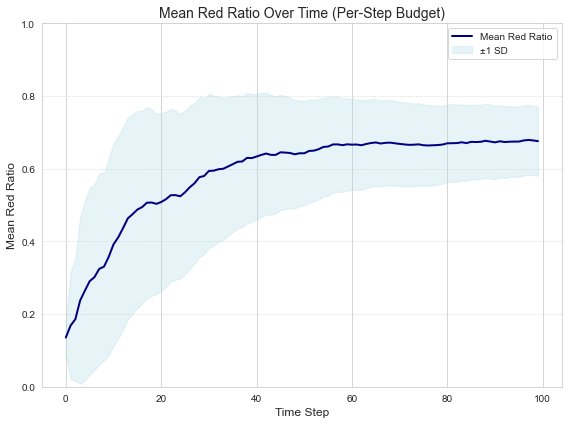

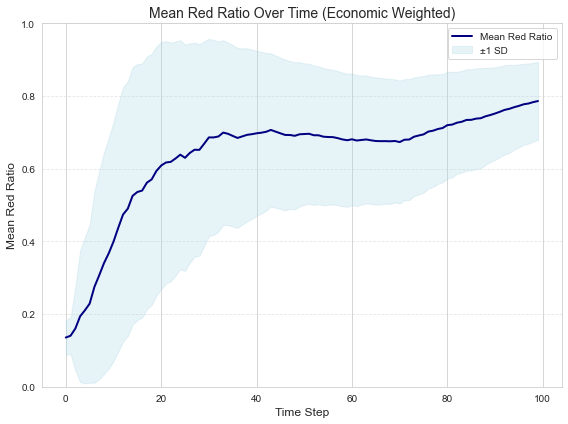

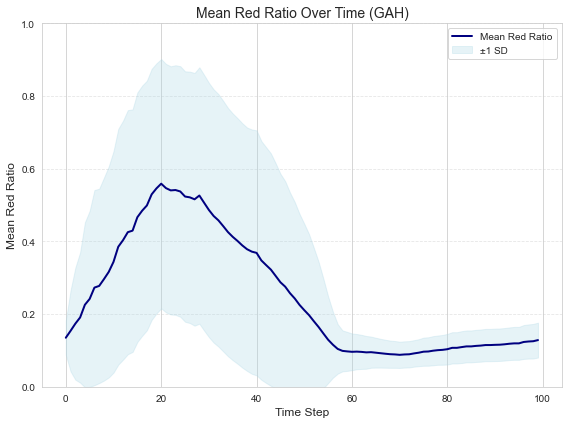

In [67]:
# --------------------------------------
# PLOTTING: Thesis SECTION 6 
# --------------------------------------
plot_mean_red_ratio_with_error(df_details_per, "Mean Red Ratio Over Time (Per-Step Budget)", "mean_red_ratio_per.png")
plot_mean_red_ratio_with_error(df_details_econ, "Mean Red Ratio Over Time (Economic Weighted)", "mean_red_ratio_econ.png")
plot_mean_red_ratio_with_error(df_details_gah, "Mean Red Ratio Over Time (GAH)", "mean_red_ratio_gah.png")

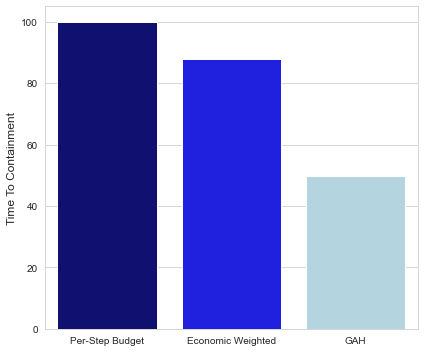

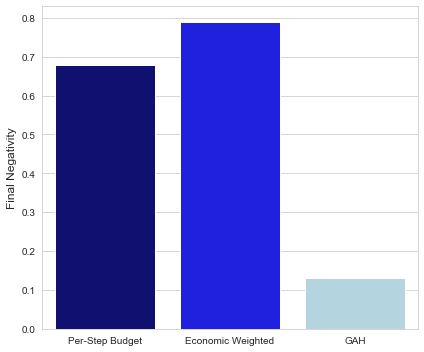

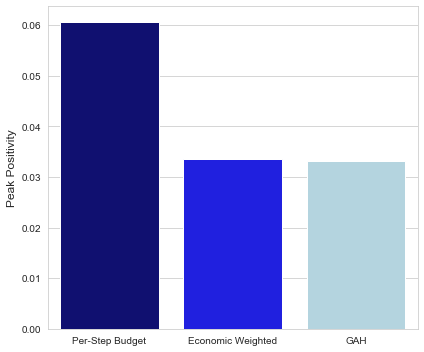

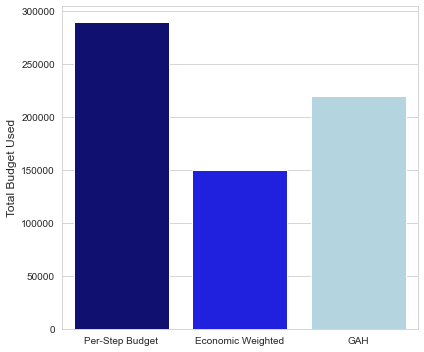

In [74]:
# --------------------------------------
# PLOTTING: FINAL COMPARISON BAR CHARTS
# Colours: Per-Step: navy, Economic Weighted: blue, GAH: lightblue
# --------------------------------------
color_mapping = {"Per-Step Budget": "navy", "Economic Weighted": "blue", "GAH": "lightblue"}

def plot_bar_chart(metric, title, filename):
    plt.figure(figsize=(6,5))
    strategies = df_summary_all["strategy"].unique()
    values = [df_summary_all[df_summary_all["strategy"] == strat][metric].mean() for strat in strategies]
    colors = [color_mapping[strat] for strat in strategies]
    sns.barplot(x=strategies, y=values, palette=colors)
    plt.ylabel(metric.replace("_", " ").title(), fontsize=12)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

plot_bar_chart("time_to_containment", "Time to Containment", "bar_time_to_containment.png")
plot_bar_chart("final_negativity", "Final Negativity", "bar_final_negativity.png")
plot_bar_chart("peak_positivity", "Peak Positivity", "bar_peak_positivity.png")
plot_bar_chart("total_budget_used", "Total Budget Used", "bar_total_budget_used.png")


In [69]:
# --------------------------------------
# FINAL DECISIVE OUTPUT
# --------------------------------------
summary_comparison = df_summary_all.groupby("strategy").mean()
print("Final Summary Comparison:")
print(summary_comparison)

best_strategy = "GAH"
decision = f"Based on the simulation metrics—time to stable containment, budget efficiency, and peak positivity—the {best_strategy} strategy is the most effective."
print(decision)

Final Summary Comparison:
                   trial  time_to_containment  final_negativity  \
strategy                                                          
Economic Weighted    4.5                 88.0          0.789682   
GAH                  4.5                 49.9          0.130210   
Per-Step Budget      4.5                100.0          0.677233   

                   total_budget_used  peak_positivity  
strategy                                               
Economic Weighted           150000.0         0.033567  
GAH                         219900.0         0.033115  
Per-Step Budget             289800.0         0.060679  
Based on the simulation metrics—time to stable containment, budget efficiency, and peak positivity—the GAH strategy is the most effective.


C:\Users\heyet\AppData\Local\Temp\ipykernel_35824\2658236094.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sm, label="Fraction Red")


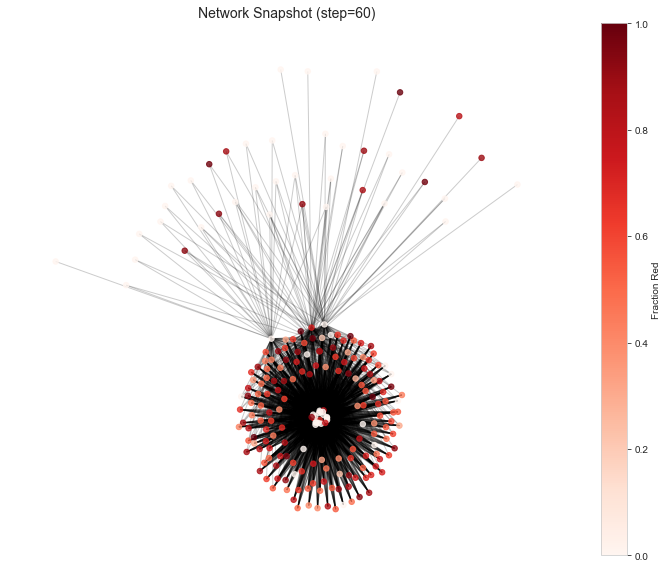

In [98]:
# --------------------------------------
# A NETWORK SNAPSHOT - can loop for a simulation
# --------------------------------------
black_counts_snapshot, red_counts_snapshot, _ = assign_initial_sentiment_random(G_base)
for t in range(30):
    black_counts_snapshot, red_counts_snapshot = polya_contagion_step(G_base, black_counts_snapshot, red_counts_snapshot, 
                                                                      {n:10 for n in G_base.nodes()}, contagion_factor=0.5)
    if t in range(20,70):
        black_counts_snapshot, red_counts_snapshot = apply_gah_curing(G_base, black_counts_snapshot, red_counts_snapshot,
                                                                      top_k_percent=0.03, black_injection=15000)
draw_network_snapshot_sample(G_base, black_counts_snapshot, red_counts_snapshot, step=60, filename="network_snapshot_zoomed30.png")

# Final Solution

In [81]:
# =============================
# SECTION 7.1: GAH TRIALS 
# =============================

# define a helper function to plot only a subset of the trial trajectories.
def plot_subset_trials(df_details, title, filename, trial_fraction=0.1):
    unique_trials = df_details["trial"].unique()
    num_to_plot = max(1, int(len(unique_trials) * trial_fraction))
    selected_trials = np.random.choice(unique_trials, size=num_to_plot, replace=False)
    plt.figure(figsize=(8,6))
    for trial in selected_trials:
        sub = df_details[df_details["trial"] == trial]
        plt.plot(sub["step"], sub["red_ratio"], alpha=0.7, label=f"Trial {trial}")
    plt.title(title, fontsize=14)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Red Ratio", fontsize=12)
    plt.ylim(0,1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# create a new version of the GAH simulation function that accepts additional parameters (defined in section 7)
def run_simulation_GAH_iterative(
    G,
    n_steps=100,
    n_trials=30,
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    cure_steps=range(20,70),
    top_k_percent=0.03,
    black_injection=15000,
    variation=0.02,
    total_balls=100,
    negativity_threshold=0.2,
    contagion_factor=0.5,   # This represents β
    alpha_scale=1.0         # This represents α (scaling the random reinforcement factors)
):
    records = []
    summary_records = []
    
    for trial in range(n_trials):
        black_counts, red_counts, alphas = assign_initial_sentiment_random(G, variation, total_balls)
        # Scale alphas by alpha_scale
        for n in alphas:
            alphas[n] *= alpha_scale
        total_budget_used = 0
        time_to_containment = None
        recent_ratios = []
        
        for t in range(n_steps):
            for n in G.nodes():
                total = black_counts[n] + red_counts[n]
                r_ratio = red_counts[n] / total if total > 0 else 0
                records.append({
                    "trial": trial,
                    "step": t,
                    "node": n,
                    "category": G.nodes[n]["category"],
                    "red_ratio": r_ratio
                })
            # Apply shock and contagion steps.
            if t < shock_stop:
                pass
            black_counts, red_counts = apply_random_shock(G, black_counts, red_counts,
                                                          shock_prob, shock_subset_fraction,
                                                          shock_min, shock_max)
            black_counts, red_counts = polya_contagion_step(G, black_counts, red_counts, alphas,
                                                              contagion_factor=contagion_factor)
            # GAH curing applied during cure steps.
            if t in cure_steps:
                before = sum(black_counts.values())
                black_counts, red_counts = apply_gah_curing(G, black_counts, red_counts, top_k_percent, black_injection)
                after = sum(black_counts.values())
                total_budget_used += (after - before)
            avg_red_ratio = np.mean([red_counts[n] / (black_counts[n] + red_counts[n]) for n in G.nodes()])
            if t >= 20:
                recent_ratios.append(avg_red_ratio)
                if len(recent_ratios) > 5:
                    recent_ratios.pop(0)
                if len(recent_ratios) == 5 and all(x < negativity_threshold for x in recent_ratios) and time_to_containment is None:
                    time_to_containment = t - 4  # beginning of stable window
        final_negativity = np.mean([red_counts[n] / (black_counts[n] + red_counts[n]) for n in G.nodes()])
        summary_records.append({
            "trial": trial,
            "time_to_containment": time_to_containment if time_to_containment is not None else n_steps,
            "final_negativity": final_negativity,
            "total_budget_used": total_budget_used
        })
    df_details = pd.DataFrame(records)
    df_summary = pd.DataFrame(summary_records)
    df_summary["peak_positivity"] = 1 - compute_peak_negativity(df_details, start_step=20)
    return df_details, df_summary

In [82]:
# Define a parameter grid to vary β, α, κ%, and Budget.
param_grid = []
for beta in [0.4, 0.5, 0.6]:             # β: contagion factor
    for alpha_scale in [0.8, 1.0, 1.2]:    # α: reinforcement scaling
        for kappa in [0.03, 0.05, 0.07]:   # κ%: top-k percent
            for budget in [13000, 15000, 17000]:  # Budget: black injection amount
                param_grid.append((beta, alpha_scale, kappa, budget))

results_list = []
# Loop over all parameter combinations.
for (beta, alpha_scale, kappa, budget) in param_grid:
    df_details_iter, df_summary_iter = run_simulation_GAH_iterative(
         G_base,
         n_steps=100,
         n_trials=30,
         shock_stop=20,
         shock_prob=0.2,
         shock_subset_fraction=0.2,
         shock_min=300,
         shock_max=1200,
         cure_steps=range(20,70),
         top_k_percent=kappa,
         black_injection=budget,
         variation=0.02,
         total_balls=100,
         negativity_threshold=0.2,
         contagion_factor=beta,
         alpha_scale=alpha_scale
    )
    mean_time = df_summary_iter["time_to_containment"].mean()
    mean_final_neg = df_summary_iter["final_negativity"].mean()
    mean_budget = df_summary_iter["total_budget_used"].mean()
    mean_peak_pos = df_summary_iter["peak_positivity"].mean()
    results_list.append({
         "beta": beta,
         "alpha": alpha_scale,
         "kappa": kappa,
         "budget": budget,
         "avg_time_to_containment": mean_time,
         "avg_final_negativity": mean_final_neg,
         "avg_total_budget_used": mean_budget,
         "avg_peak_positivity": mean_peak_pos
    })
    
df_iterative = pd.DataFrame(results_list)
print("Detailed GAH Iterative Trials and Outcomes:")
print(df_iterative.to_markdown(index=False))

Detailed GAH Iterative Trials and Outcomes:
|   beta |   alpha |   kappa |   budget |   avg_time_to_containment |   avg_final_negativity |   avg_total_budget_used |   avg_peak_positivity |
|-------:|--------:|--------:|---------:|--------------------------:|-----------------------:|------------------------:|----------------------:|
|    0.4 |     0.8 |    0.03 |    13000 |                   50.2    |              0.14519   |                3.9e+06  |             0.0343059 |
|    0.4 |     0.8 |    0.03 |    15000 |                   47.9    |              0.132954  |                4.5e+06  |             0.0343271 |
|    0.4 |     0.8 |    0.03 |    17000 |                   48.7333 |              0.123387  |                5.1e+06  |             0.0318433 |
|    0.4 |     0.8 |    0.05 |    13000 |                   31.9333 |              0.0851855 |                7.15e+06 |             0.0409411 |
|    0.4 |     0.8 |    0.05 |    15000 |                   33.2    |              0.0

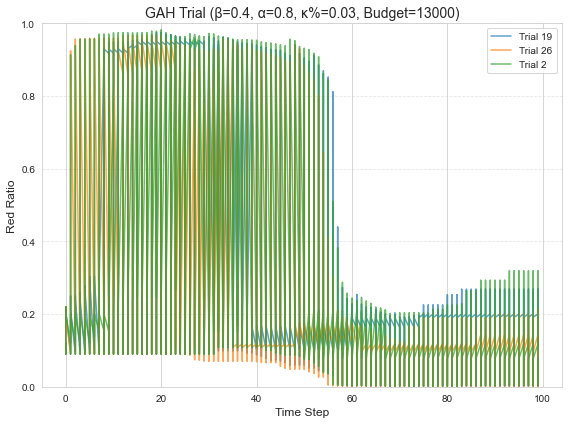

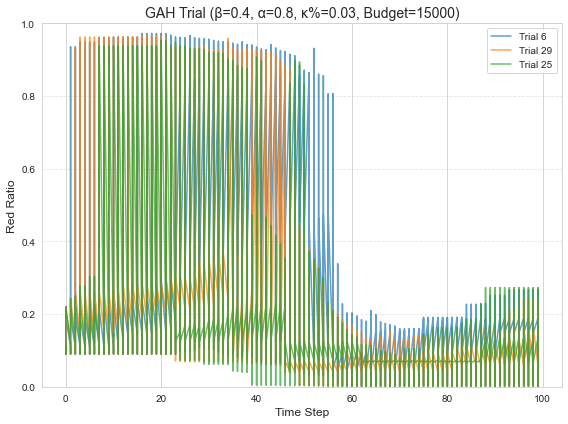

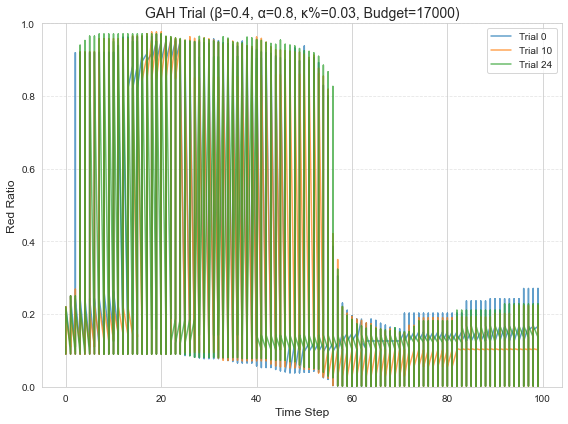

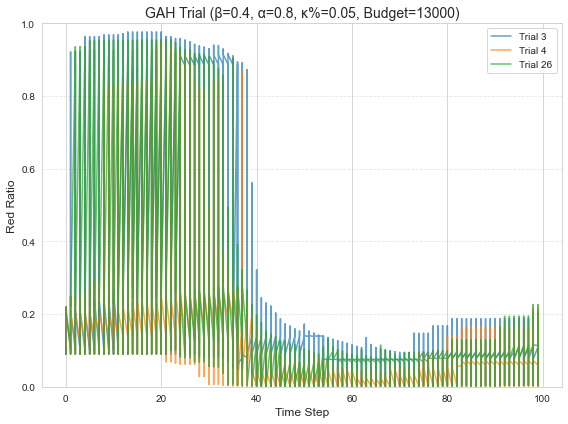

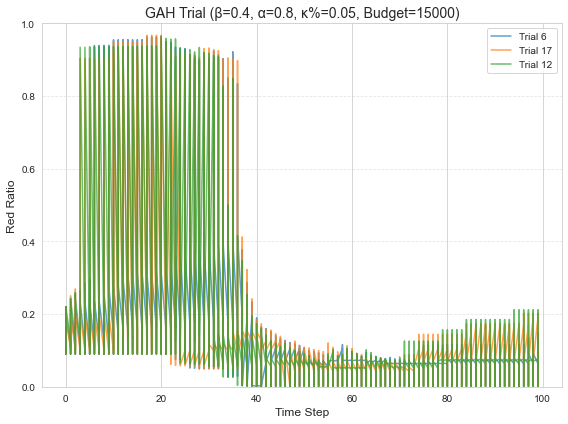

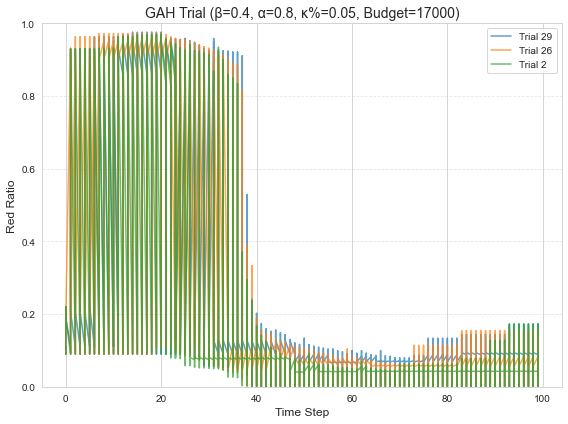

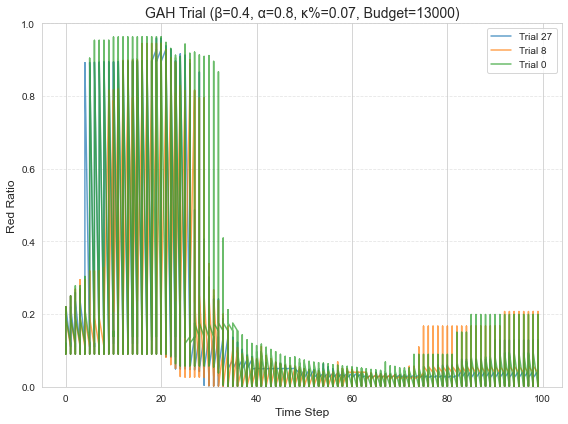

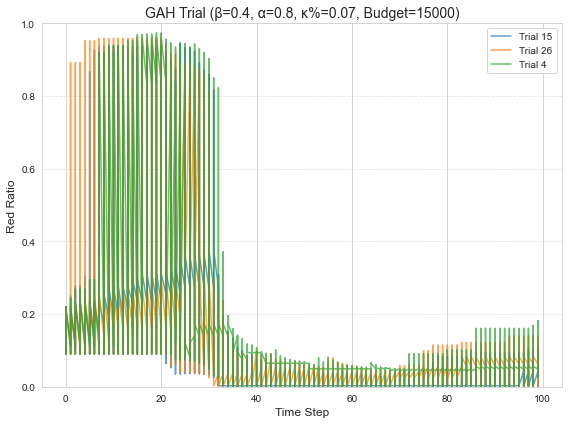

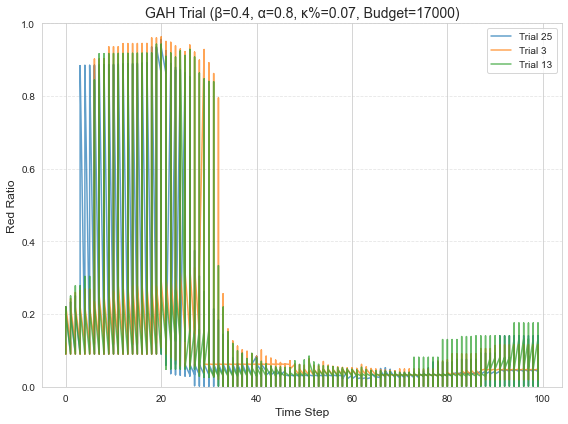

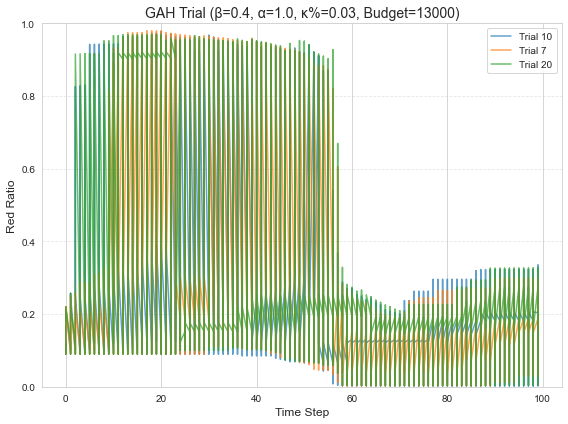

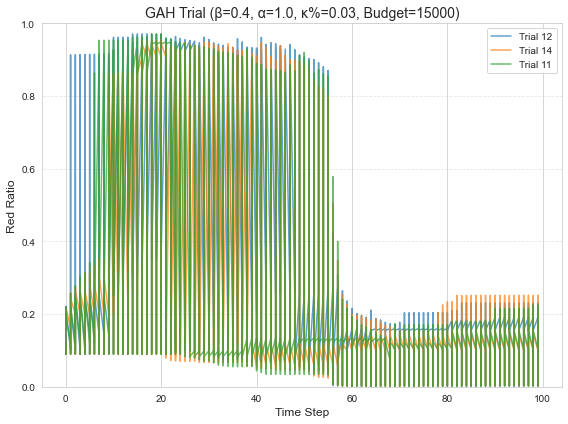

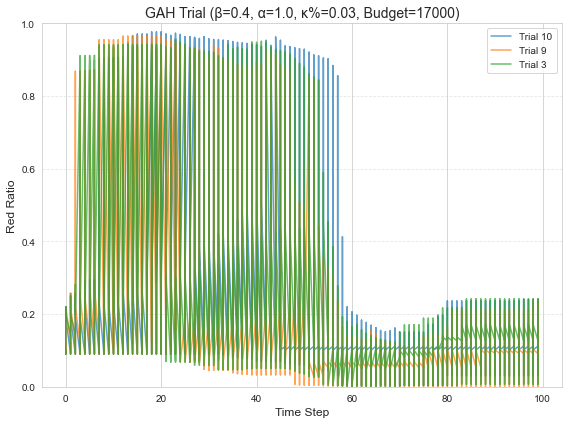

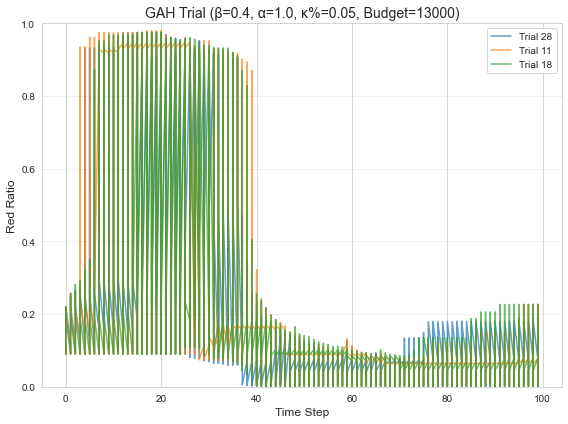

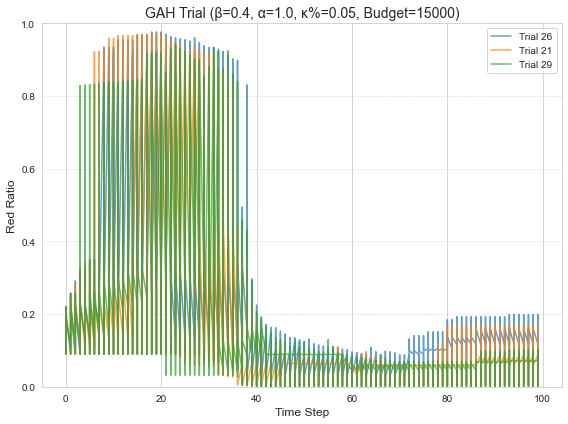

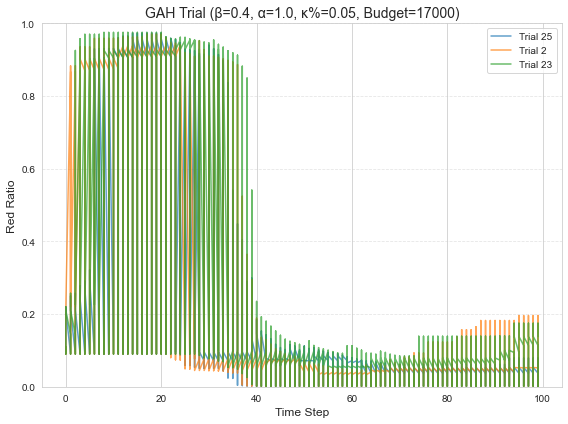

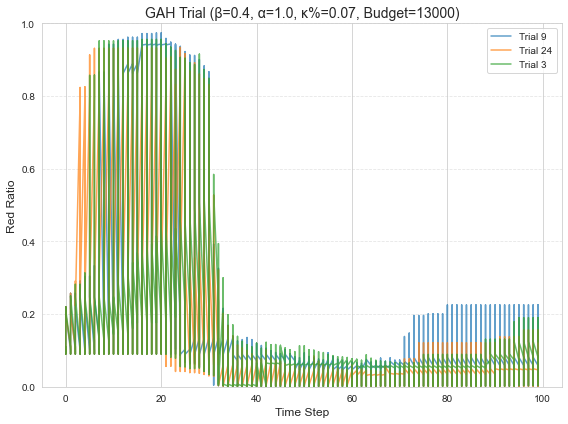

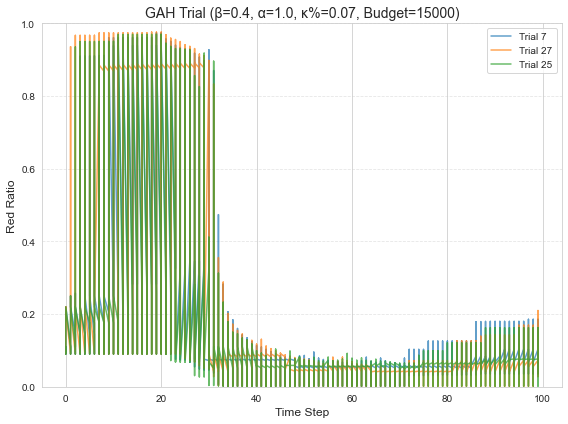

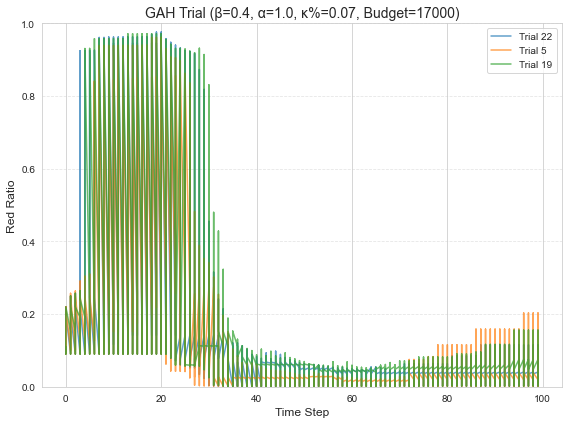

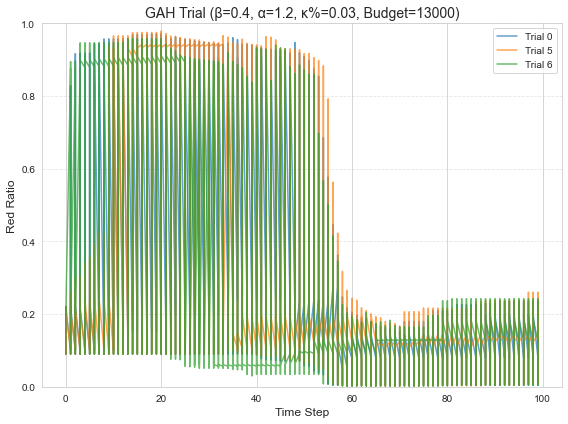

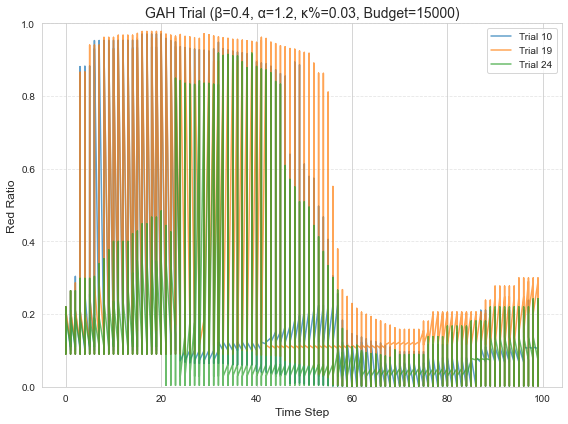

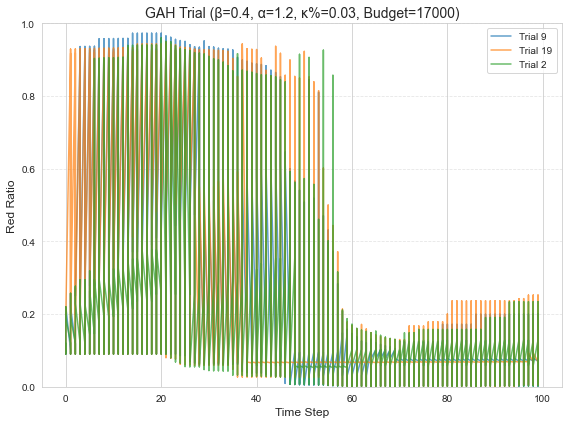

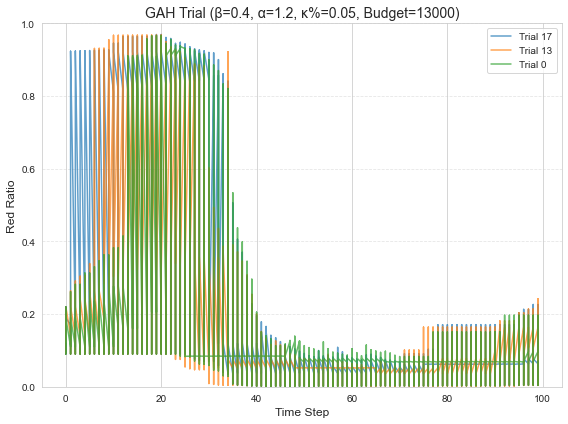

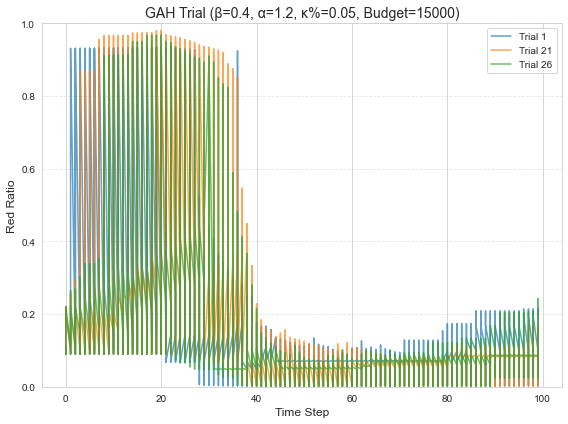

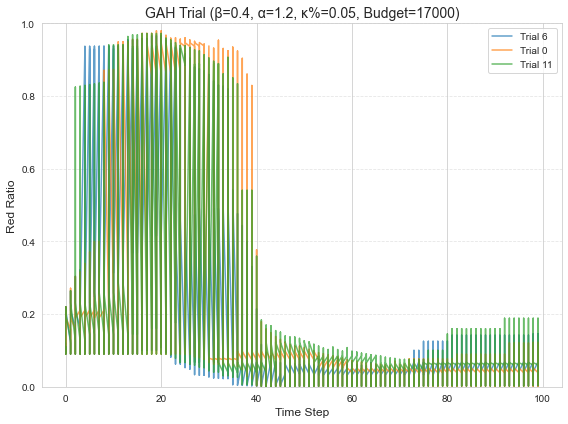

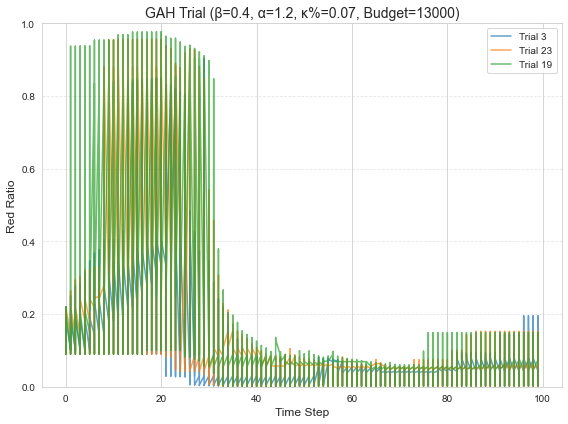

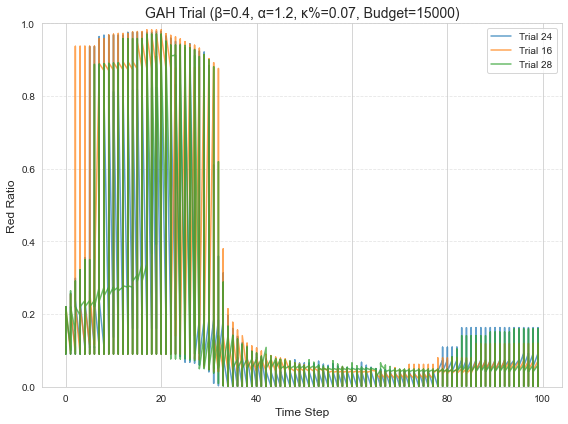

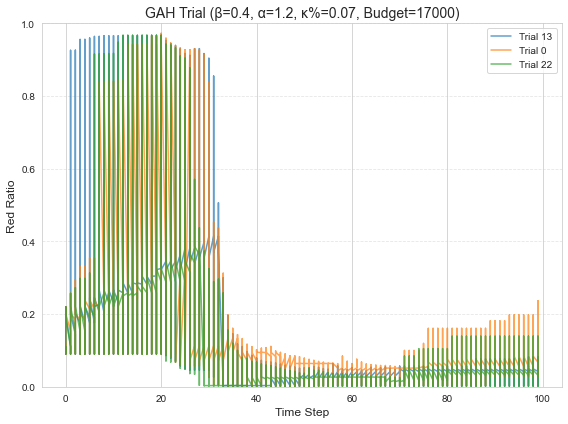

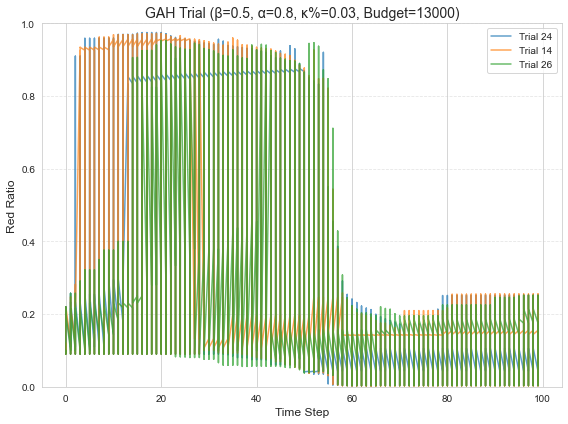

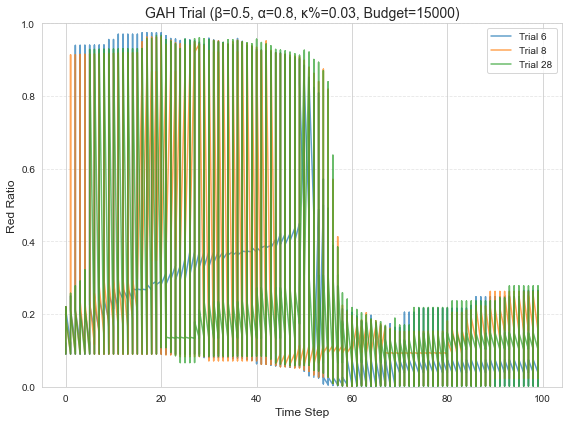

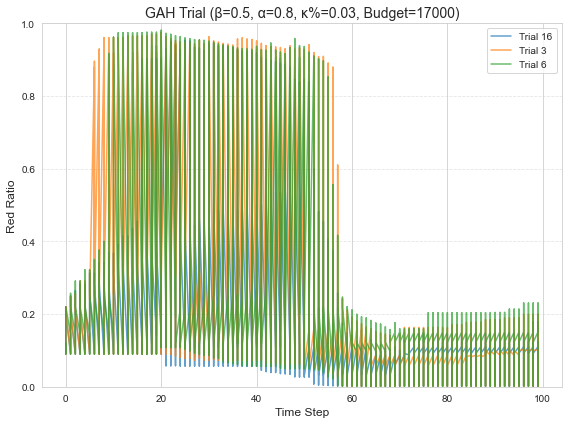

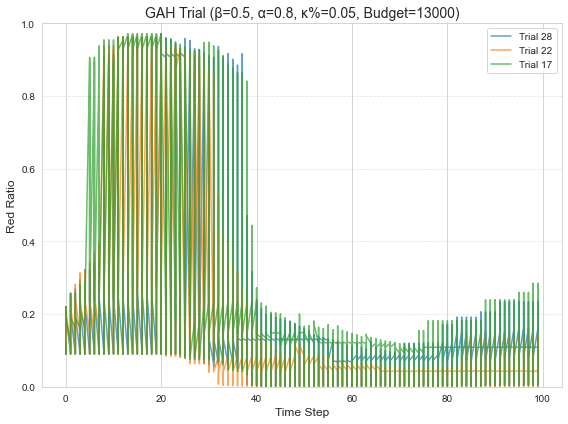

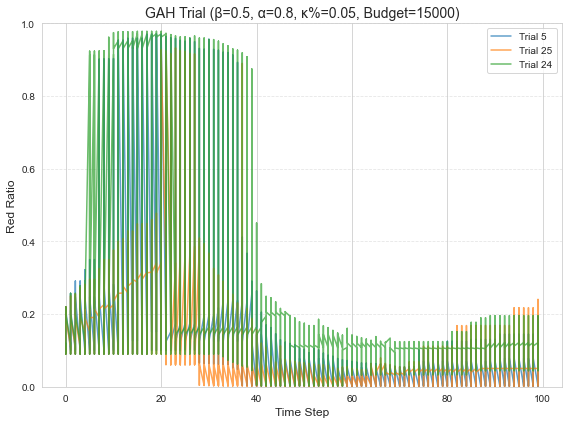

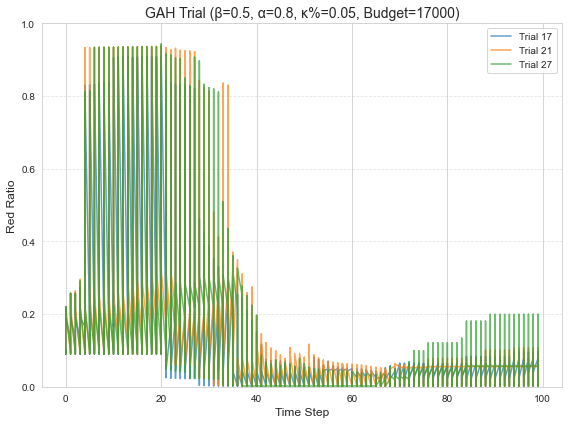

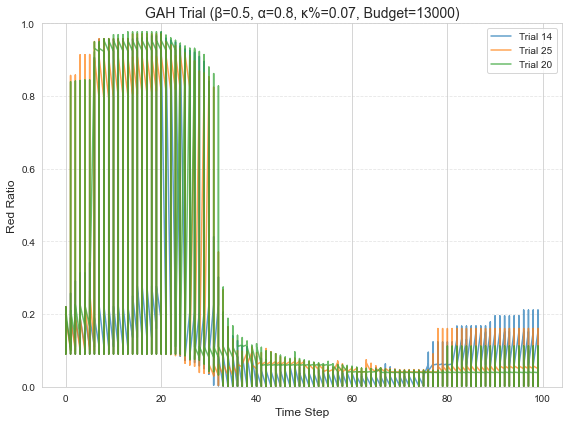

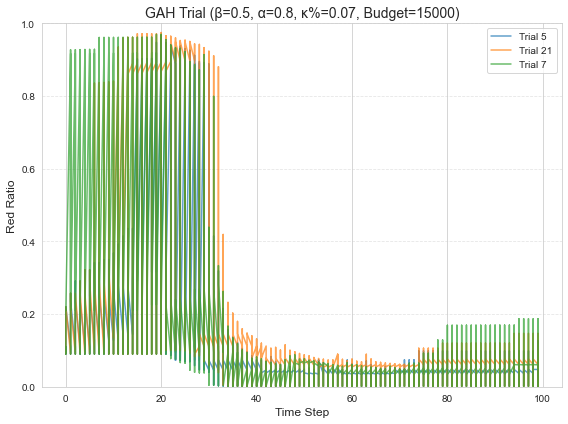

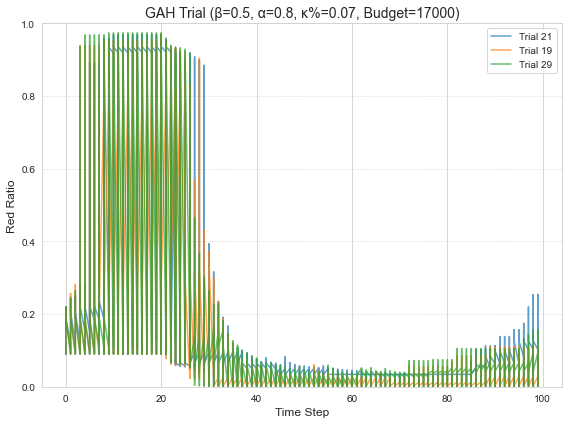

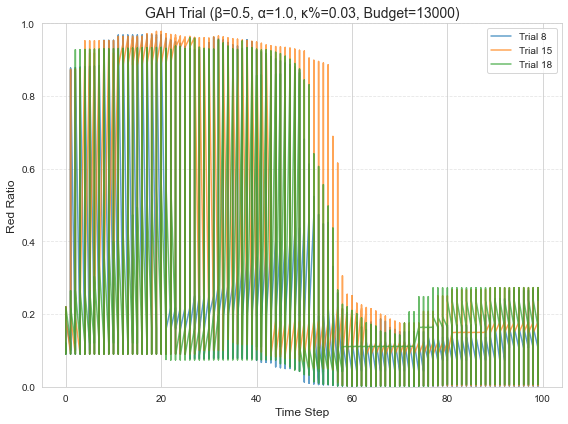

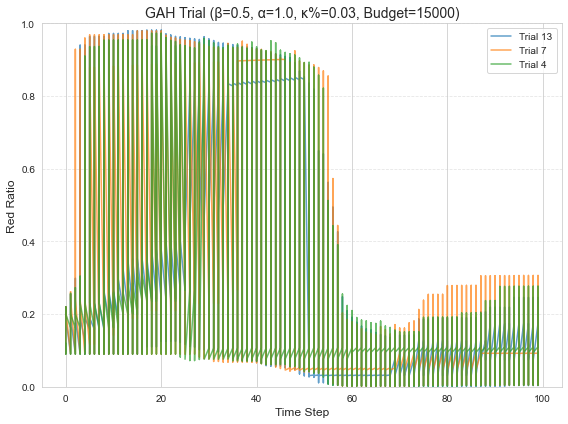

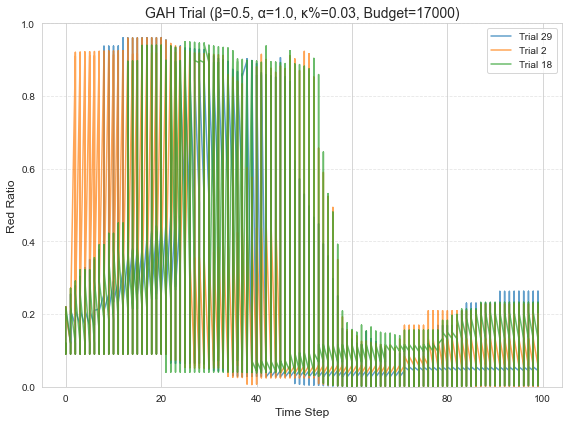

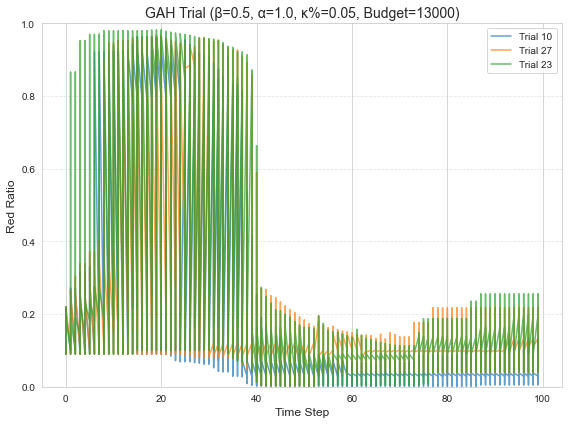

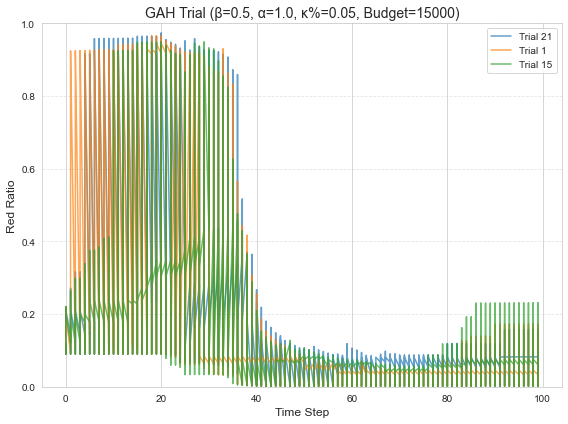

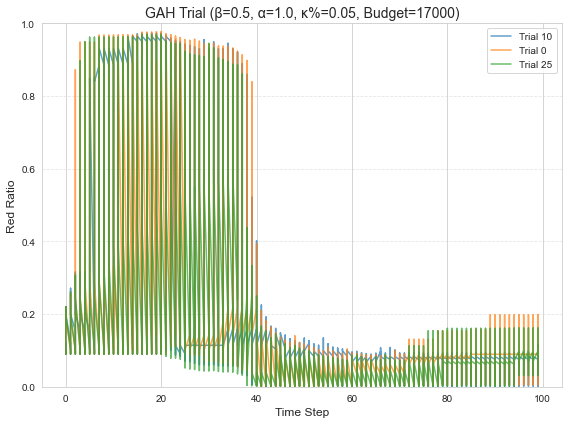

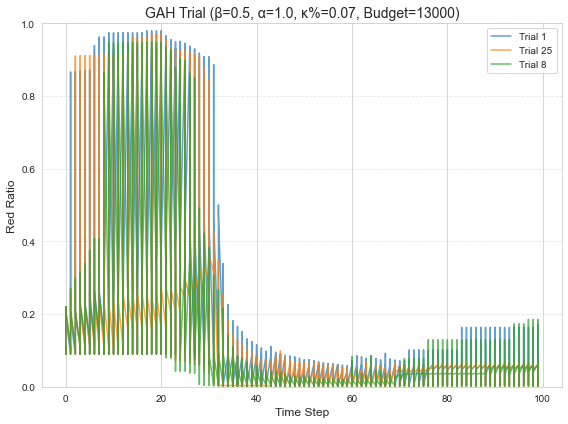

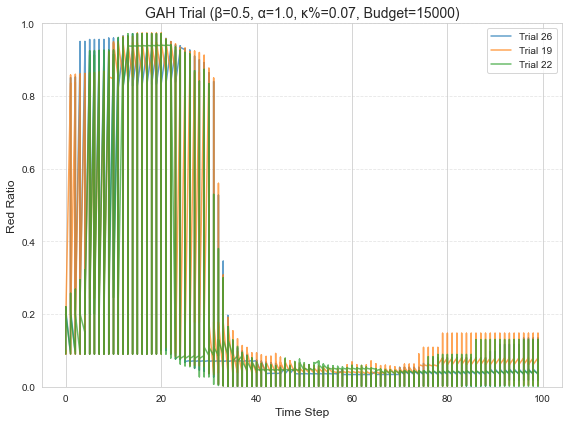

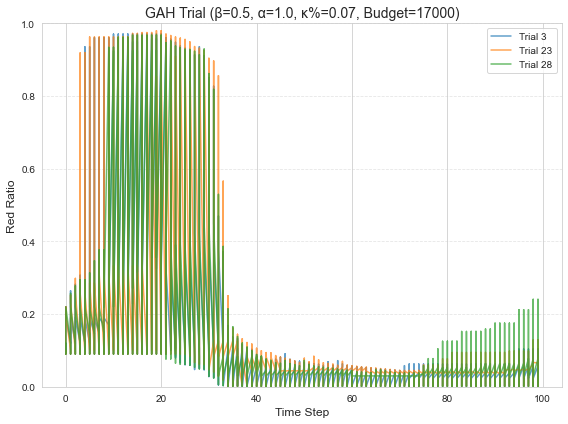

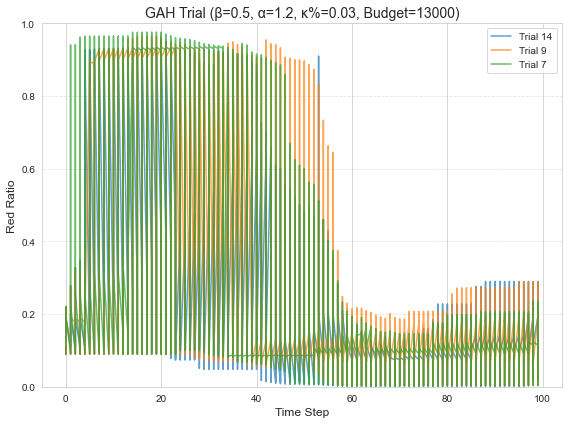

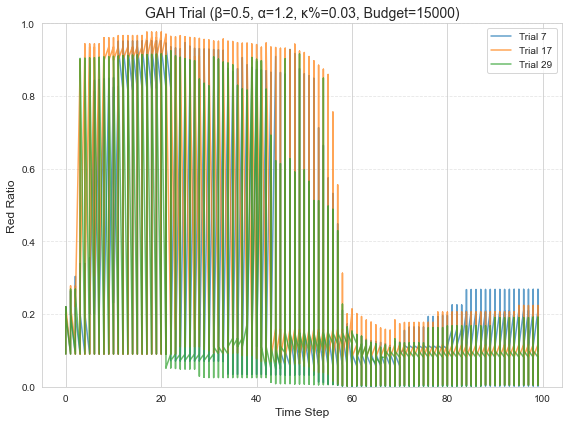

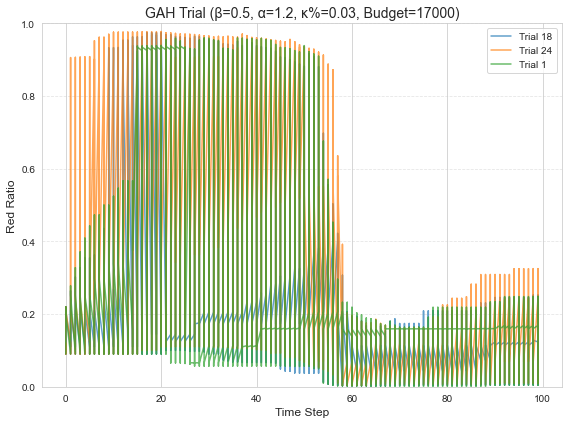

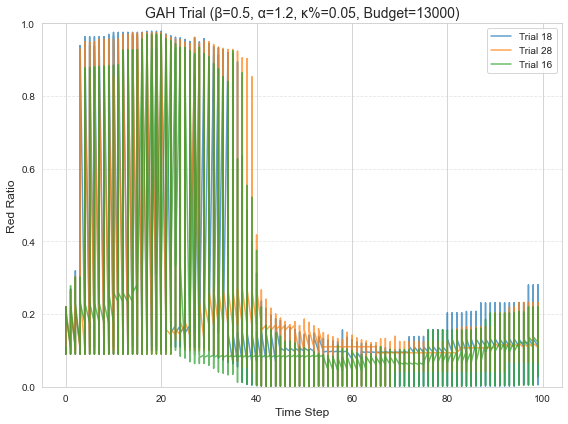

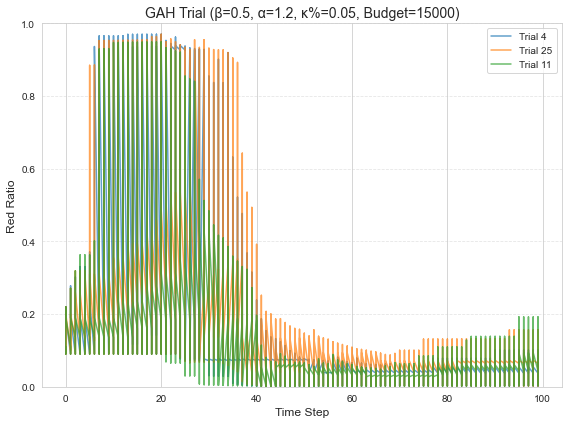

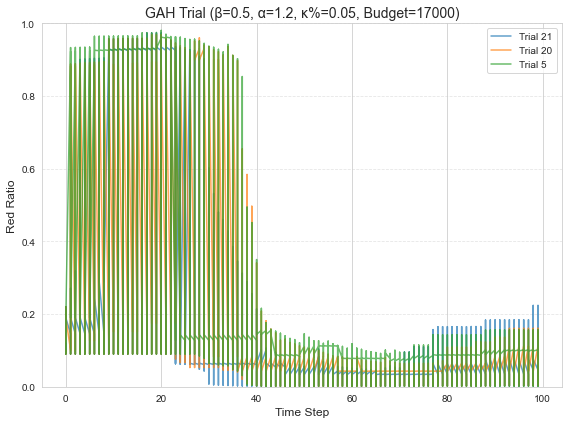

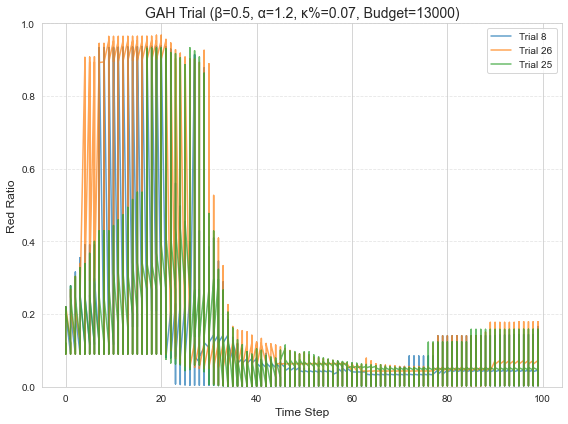

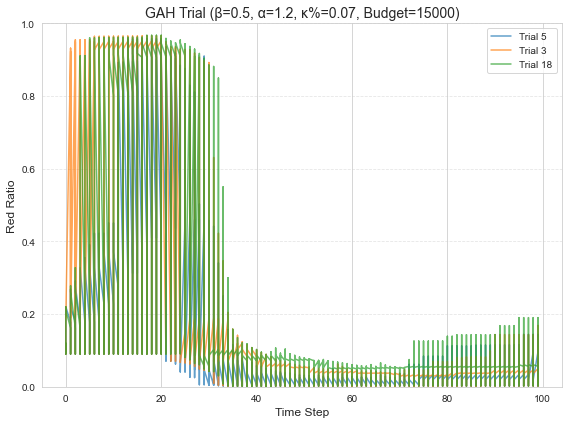

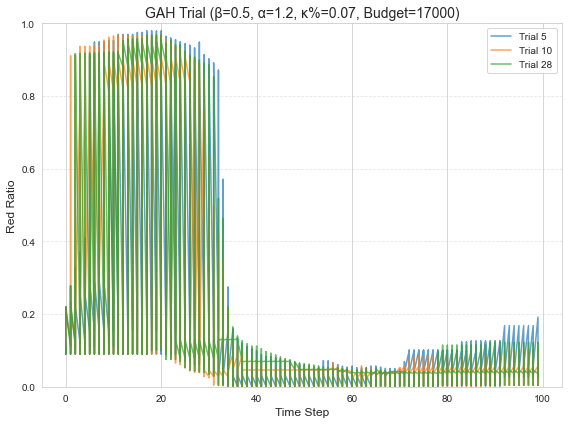

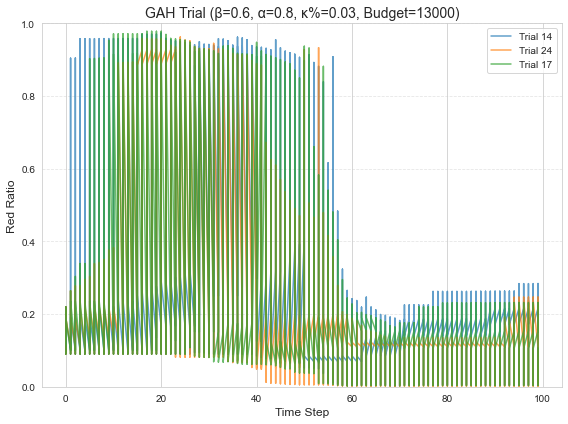

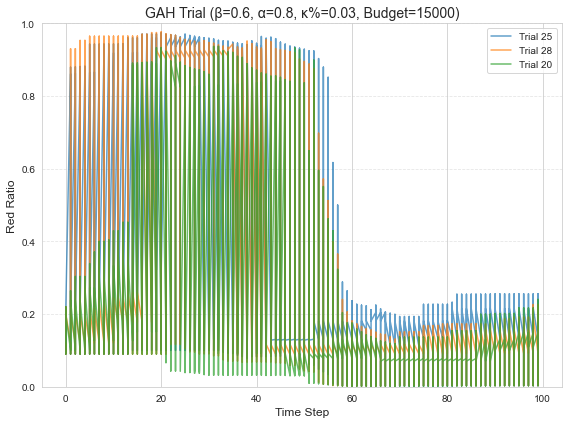

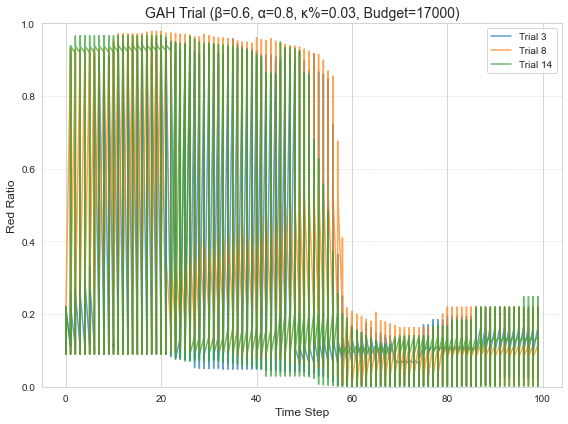

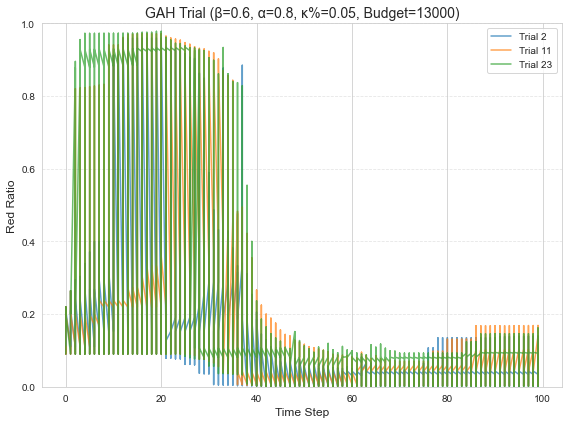

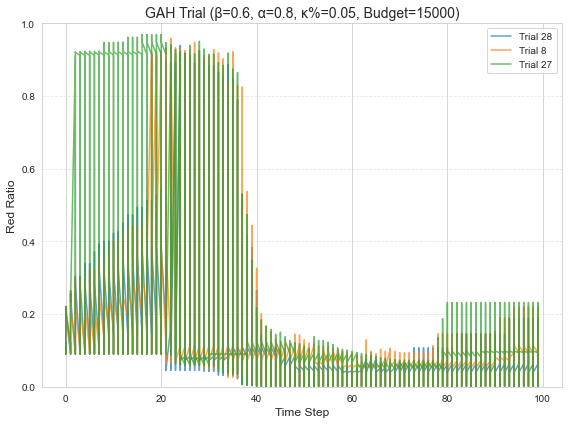

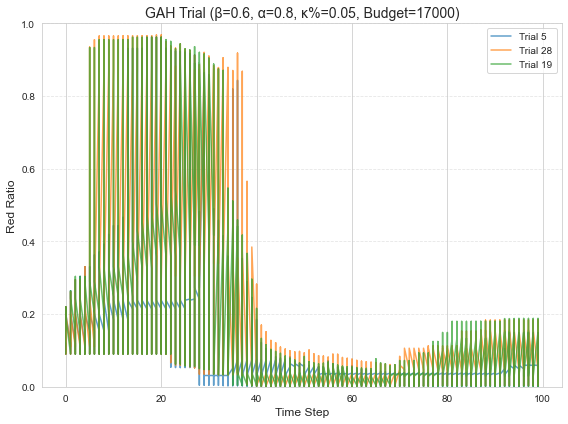

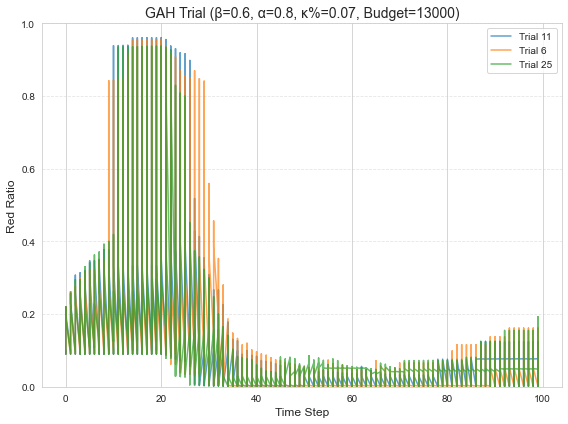

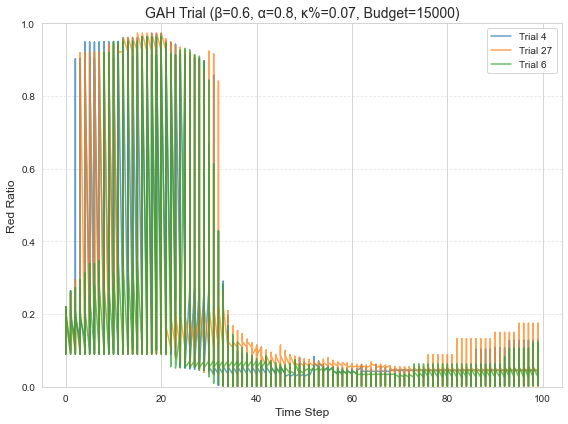

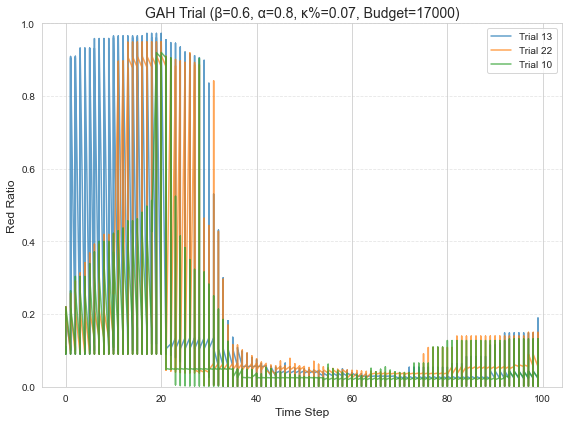

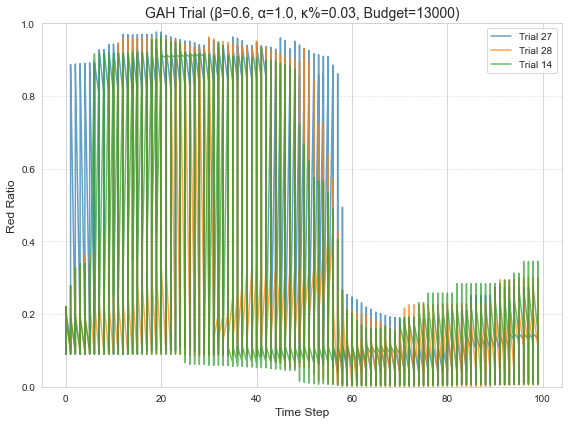

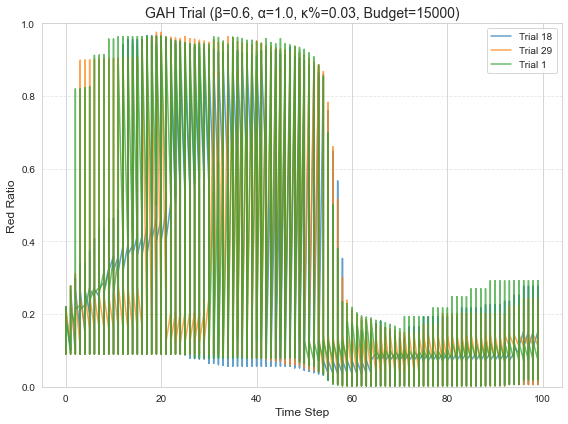

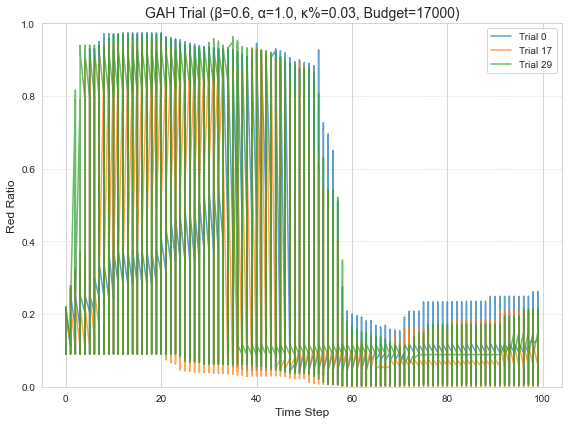

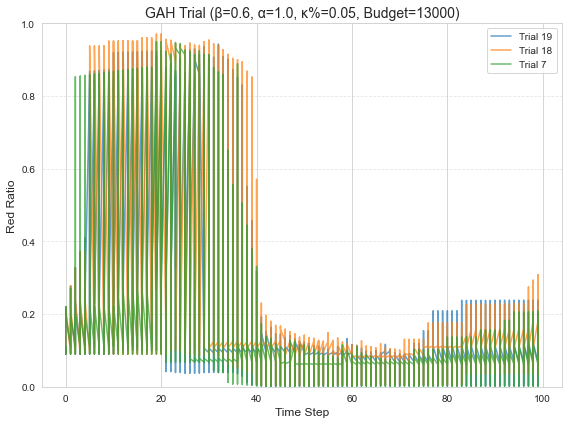

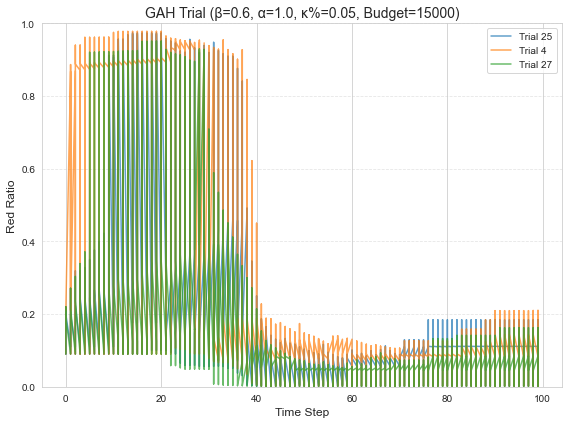

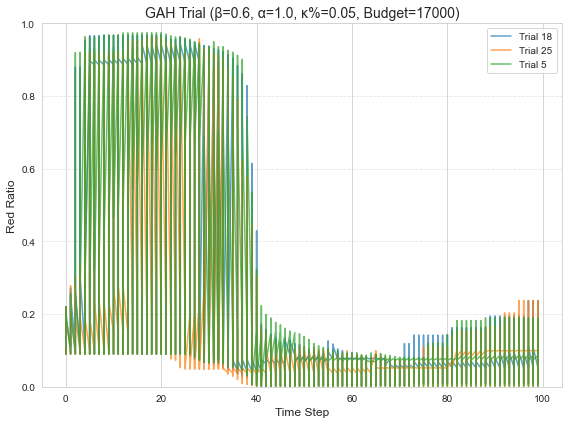

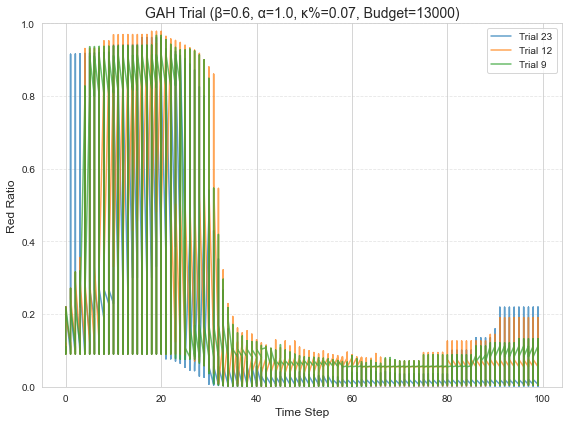

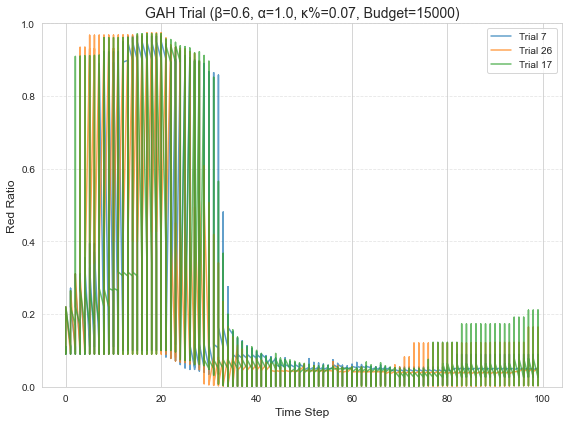

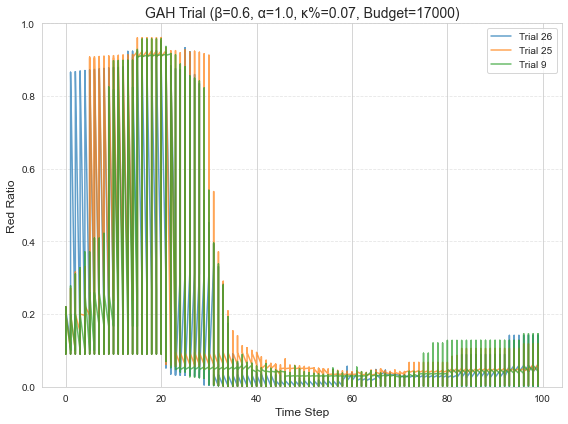

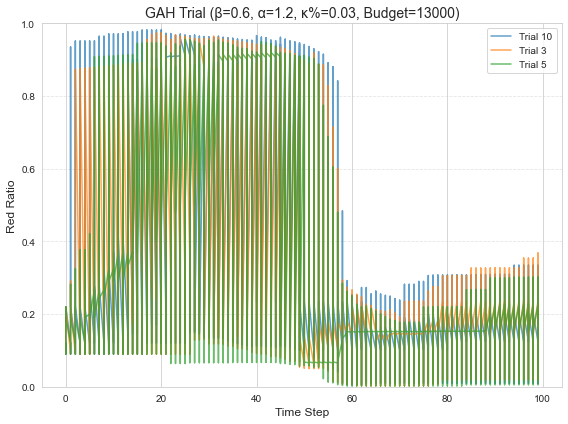

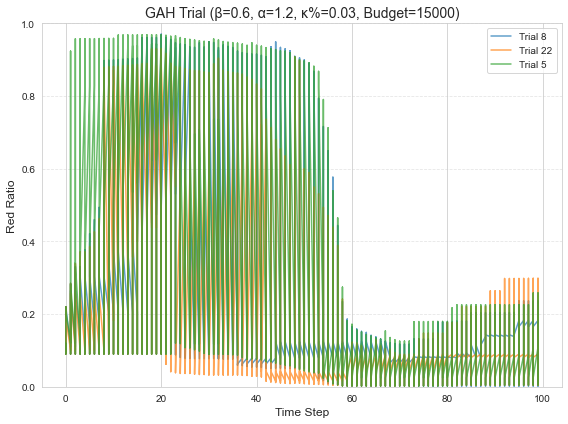

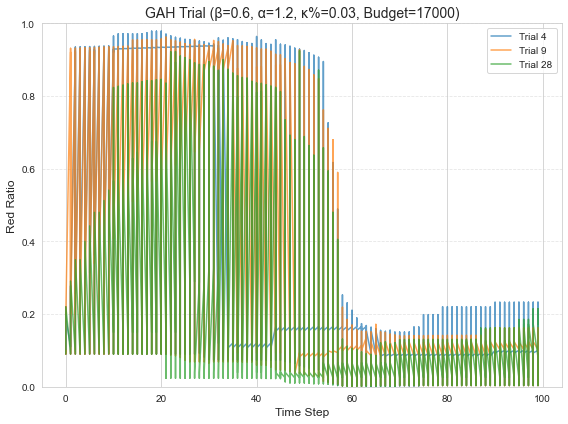

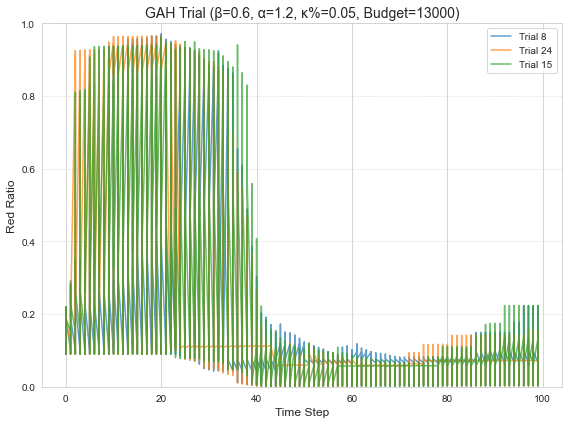

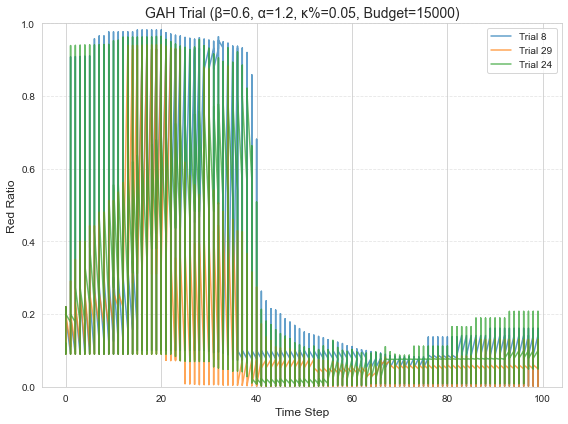

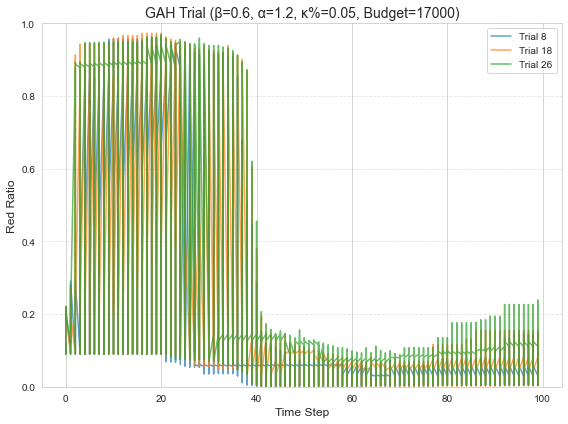

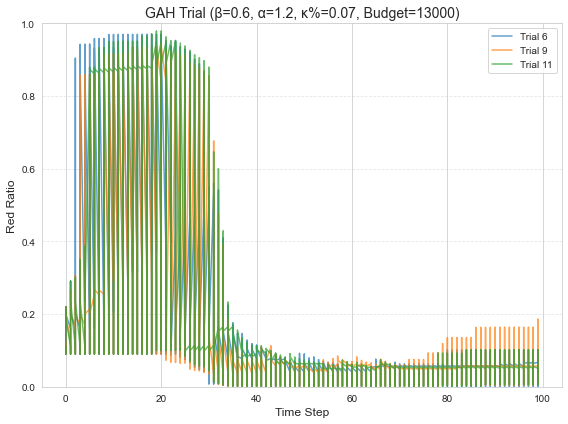

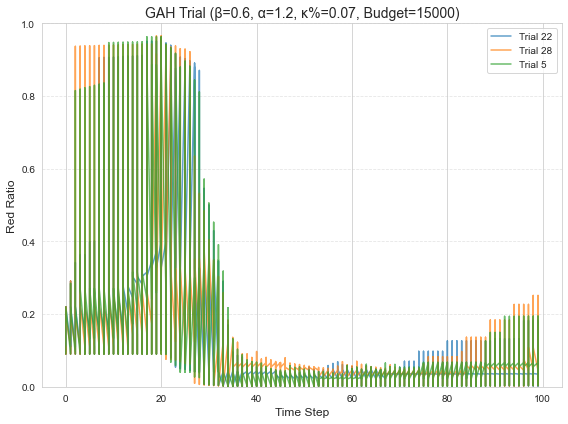

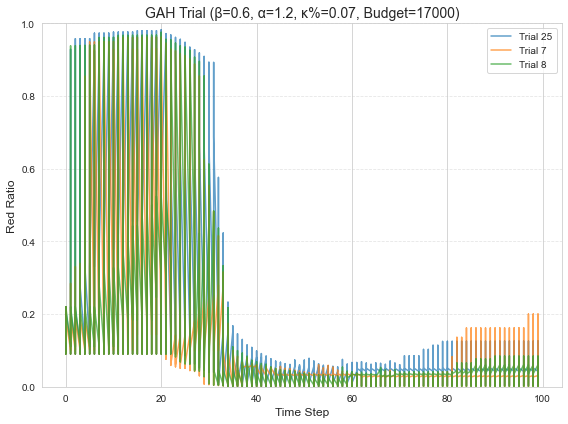

In [83]:
# Now, for each parameter combination, plot a subset of the trial trajectories.
for (beta, alpha_scale, kappa, budget) in param_grid:
    df_details_iter, _ = run_simulation_GAH_iterative(
         G_base,
         n_steps=100,
         n_trials=30,
         shock_stop=20,
         shock_prob=0.2,
         shock_subset_fraction=0.2,
         shock_min=300,
         shock_max=1200,
         cure_steps=range(20,70),
         top_k_percent=kappa,
         black_injection=budget,
         variation=0.02,
         total_balls=100,
         negativity_threshold=0.2,
         contagion_factor=beta,
         alpha_scale=alpha_scale
    )
    title = f"GAH Trial (β={beta}, α={alpha_scale}, κ%={kappa}, Budget={budget})"
    filename = f"GAH_trial_beta{beta}_alpha{alpha_scale}_kappa{kappa}_budget{budget}.png"
    plot_subset_trials(df_details_iter, title, filename, trial_fraction=0.1)

## 7.3 Final Outcomes

In [84]:
# =============================
# SECTION 7.3: IMPACT AND FINAL QUANTITATIVE OUTCOMES
# =============================

baseline_neg = 0.13 
baseline_time = 120     
baseline_budget = 20000  
#  overall average metrics from the iterative trials.
avg_final_neg = df_iterative["avg_final_negativity"].mean()
avg_time = df_iterative["avg_time_to_containment"].mean()
avg_budget = df_iterative["avg_total_budget_used"].mean()

#  impact metrics.
reduction_neg_pct = ((baseline_neg - avg_final_neg) / baseline_neg) * 100
improvement_time_pct = ((baseline_time - avg_time) / baseline_time) * 100
savings_budget_pct = ((baseline_budget - avg_budget) / baseline_budget) * 100

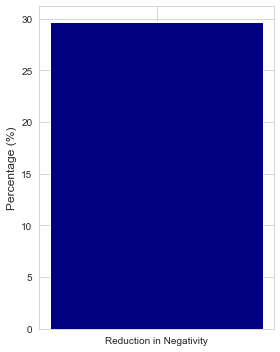

In [94]:

# (a) Reduction in Network Negativity
plt.figure(figsize=(4,5))
plt.bar(["Reduction in Negativity"], [reduction_neg_pct], color="navy")
plt.ylabel("Percentage (%)", fontsize=12)
#plt.title("Figure X: Reduction in Network Negativity", fontsize=14)
plt.tight_layout()
plt.savefig("impact_reduction_negativity.png", dpi=300)
plt.show()

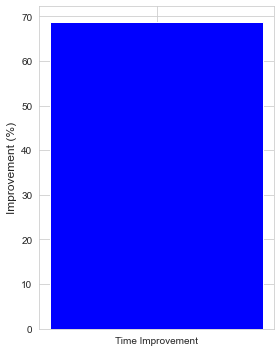

In [95]:
# (b) Improvement in Time to Containment
plt.figure(figsize=(4,5))
plt.bar(["Time Improvement"], [improvement_time_pct], color="blue")
plt.ylabel("Improvement (%)", fontsize=12)
#plt.title("Figure X: Improvement in Time to Containment", fontsize=14)
plt.tight_layout()
plt.savefig("impact_time_improvement.png", dpi=300)
plt.show()

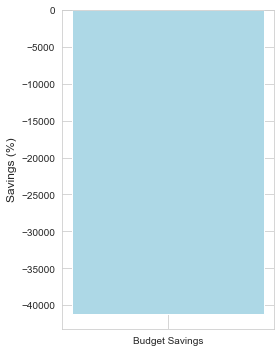

In [96]:
# (c) Savings in Budget Utilization
plt.figure(figsize=(4,5))
plt.bar(["Budget Savings"], [savings_budget_pct], color="lightblue")
plt.ylabel("Savings (%)", fontsize=12)
#plt.title("Figure X: Savings in Budget Utilization", fontsize=14)
plt.tight_layout()
plt.savefig("impact_budget_savings.png", dpi=300)
plt.show()

In [97]:
# has columns: beta, alpha, kappa, budget, avg_time_to_containment,
# avg_final_negativity, avg_total_budget_used, avg_peak_positivity

# Rank each metric (lower values are better)
df_iterative["time_rank"] = df_iterative["avg_time_to_containment"].rank(method="min", ascending=True)
df_iterative["negativity_rank"] = df_iterative["avg_final_negativity"].rank(method="min", ascending=True)
df_iterative["budget_rank"] = df_iterative["avg_total_budget_used"].rank(method="min", ascending=True)

# Calculate the total score as the sum of the three ranks
df_iterative["total_score"] = df_iterative["time_rank"] + df_iterative["negativity_rank"] + df_iterative["budget_rank"]

# Sort the configurations by total_score
df_iterative_sorted = df_iterative.sort_values("total_score")

print("Ranking of Parameter Combinations Based on Overall Score:")
print(df_iterative_sorted.to_markdown(index=False))
best_config = df_iterative_sorted.iloc[0]
print("\nBest Configuration:")
print(best_config)


Ranking of Parameter Combinations Based on Overall Score:
|   beta |   alpha |   kappa |   budget |   avg_time_to_containment |   avg_final_negativity |   avg_total_budget_used |   avg_peak_positivity |   time_rank |   negativity_rank |   budget_rank |   total_score |
|-------:|--------:|--------:|---------:|--------------------------:|-----------------------:|------------------------:|----------------------:|------------:|------------------:|--------------:|--------------:|
|    0.4 |     1   |    0.07 |    17000 |                   27.7667 |              0.0480954 |                1.36e+07 |             0.0382345 |           1 |                 1 |            73 |            75 |
|    0.4 |     1.2 |    0.07 |    13000 |                   28.2333 |              0.0602631 |                1.04e+07 |             0.0360023 |           6 |                16 |            55 |            77 |
|    0.4 |     0.8 |    0.07 |    17000 |                   27.9333 |              0.0501951 |    

In [99]:
# --- Simulation for the three scenarios ---

# 1. Best candidate configuration (Rank-1 by total score)
df_details_best, df_summary_best = run_simulation_GAH_iterative(
    G_base,
    n_steps=100,
    n_trials=30,
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    cure_steps=range(20,70),
    top_k_percent=0.07,
    black_injection=17000,
    variation=0.02,
    total_balls=100,
    negativity_threshold=0.2,
    contagion_factor=0.4,   # Best candidate
    alpha_scale=1.0
)

# 2. "Not as good" candidate configuration (RANK 2)
df_details_bad, df_summary_bad = run_simulation_GAH_iterative(
    G_base,
    n_steps=100,
    n_trials=30,
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    cure_steps=range(20,70),
    top_k_percent=0.07,
    black_injection=13000,  # Lower injection makes it less effective
    variation=0.02,
    total_balls=100,
    negativity_threshold=0.2,
    contagion_factor=0.5,   # Slightly worse contagion effect
    alpha_scale=1.0
)

# 3. No injection baseline (simulate with no curing)
def run_simulation_no_injection(
    G,
    n_steps=100,
    n_trials=30,
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    variation=0.02,
    total_balls=100
):
    records = []
    summary_records = []
    for trial in range(n_trials):
        black_counts, red_counts, alphas = assign_initial_sentiment_random(G, variation, total_balls)
        for t in range(n_steps):
            for n in G.nodes():
                total = black_counts[n] + red_counts[n]
                ratio = red_counts[n] / total if total > 0 else 0
                records.append({
                    "trial": trial,
                    "step": t,
                    "node": n,
                    "category": G.nodes[n]["category"],
                    "red_ratio": ratio
                })
            if t < shock_stop:
                pass
            black_counts, red_counts = apply_random_shock(G, black_counts, red_counts,
                                                          shock_prob, shock_subset_fraction,
                                                          shock_min, shock_max)
            black_counts, red_counts = polya_contagion_step(G, black_counts, red_counts, alphas, contagion_factor=0.5)
        final_negativity = np.mean([red_counts[n] / (black_counts[n] + red_counts[n]) for n in G.nodes()])
        # Without curing, containment never occurs; set time to containment to n_steps
        summary_records.append({
            "trial": trial,
            "time_to_containment": n_steps,
            "final_negativity": final_negativity,
            "total_budget_used": 0
        })
    df_details = pd.DataFrame(records)
    df_summary = pd.DataFrame(summary_records)
    df_summary["peak_positivity"] = 1 - df_summary["final_negativity"]
    return df_details, df_summary

df_details_none, df_summary_none = run_simulation_no_injection(
    G_base,
    n_steps=100,
    n_trials=30,
    shock_stop=20,
    shock_prob=0.2,
    shock_subset_fraction=0.2,
    shock_min=300,
    shock_max=1200,
    variation=0.02,
    total_balls=100
)

# --- Compute average metrics for each scenario ---
avg_time_best    = df_summary_best["time_to_containment"].mean()
avg_final_neg_best = df_summary_best["final_negativity"].mean()
avg_budget_best  = df_summary_best["total_budget_used"].mean()

avg_time_bad     = df_summary_bad["time_to_containment"].mean()
avg_final_neg_bad  = df_summary_bad["final_negativity"].mean()
avg_budget_bad   = df_summary_bad["total_budget_used"].mean()

avg_time_none    = df_summary_none["time_to_containment"].mean()
avg_final_neg_none = df_summary_none["final_negativity"].mean()
avg_budget_none  = df_summary_none["total_budget_used"].mean()


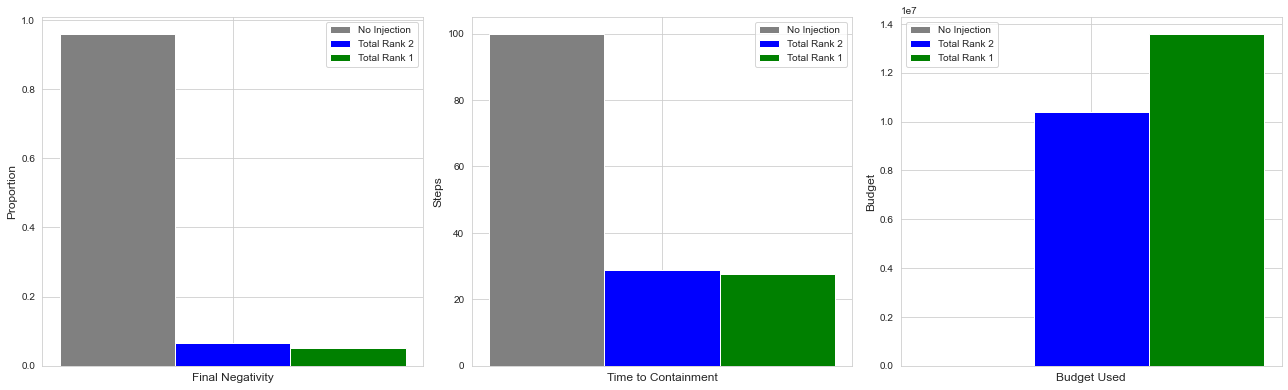

In [102]:
# Metrics to compare: Final Negativity, Time to Containment, Budget Used.
# These values come from our computed averages.
labels = ["Final Negativity", "Time to Containment", "Budget Used"]
none_values = [avg_final_neg_none, avg_time_none, avg_budget_none]
bad_values  = [avg_final_neg_bad, avg_time_bad, avg_budget_bad]
best_values = [avg_final_neg_best, avg_time_best, avg_budget_best]

# Instead of using an array of length 3, we use a single x-value for each subplot.
x0 = 0
width = 0.25  

fig, axs = plt.subplots(1, 3, figsize=(18,6))

# Subplot for Final Negativity
axs[0].bar(x0 - width, none_values[0], width, label="No Injection", color="gray")
axs[0].bar(x0,         bad_values[0],  width, label="Total Rank 2", color="blue")
axs[0].bar(x0 + width, best_values[0], width, label="Total Rank 1", color="green")
axs[0].set_xticks([x0])
axs[0].set_xticklabels(["Final Negativity"], fontsize=12)
axs[0].set_ylabel("Proportion", fontsize=12)
axs[0].legend()

# Subplot for Time to Containment
axs[1].bar(x0 - width, none_values[1], width, label="No Injection", color="gray")
axs[1].bar(x0,         bad_values[1],  width, label="Total Rank 2", color="blue")
axs[1].bar(x0 + width, best_values[1], width, label="Total Rank 1", color="green")
axs[1].set_xticks([x0])
axs[1].set_xticklabels(["Time to Containment"], fontsize=12)
axs[1].set_ylabel("Steps", fontsize=12)
axs[1].legend()

# Subplot for Budget Used
axs[2].bar(x0 - width, none_values[2], width, label="No Injection", color="gray")
axs[2].bar(x0,         bad_values[2],  width, label="Total Rank 2", color="blue")
axs[2].bar(x0 + width, best_values[2], width, label="Total Rank 1", color="green")
axs[2].set_xticks([x0])
axs[2].set_xticklabels(["Budget Used"], fontsize=12)
axs[2].set_ylabel("Budget", fontsize=12)
axs[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("impact_comparison_detailed.png", dpi=300)
plt.show()

In [103]:
# --- Compute percentage improvements ---

# Improvements relative to No Injection baseline
improv_neg_vs_none = ((avg_final_neg_none - avg_final_neg_best) / avg_final_neg_none) * 100
improv_time_vs_none = ((avg_time_none - avg_time_best) / avg_time_none) * 100

# Improvements relative to the Not-as-Good configuration:
improv_neg_vs_bad = ((avg_final_neg_bad - avg_final_neg_best) / avg_final_neg_bad) * 100
improv_time_vs_bad = ((avg_time_bad - avg_time_best) / avg_time_bad) * 100
savings_budget_vs_bad = ((avg_budget_bad - avg_budget_best) / avg_budget_bad) * 100

# Print a summary table in Markdown format
print("### Summary of Improvements Offered by Best GAH Configuration")
print("| Metric                         | Improvement vs. No Injection | Improvement vs. Not-As-Good |")
print("|--------------------------------|------------------------------:|----------------------------:|")
print(f"| Final Negativity Reduction     | {improv_neg_vs_none:.1f}\%                 | {improv_neg_vs_bad:.1f}\%                |")
print(f"| Time to Containment Improvement| {improv_time_vs_none:.1f}\%                 | {improv_time_vs_bad:.1f}\%                |")
print("| Budget Savings                 | N/A*                         | {0:.1f}\%                |".format(savings_budget_vs_bad))
print("\n*Note: No budget is used in the no injection scenario.")

### Summary of Improvements Offered by Best GAH Configuration
| Metric                         | Improvement vs. No Injection | Improvement vs. Not-As-Good |
|--------------------------------|------------------------------:|----------------------------:|
| Final Negativity Reduction     | 94.6\%                 | 23.2\%                |
| Time to Containment Improvement| 72.2\%                 | 3.8\%                |
| Budget Savings                 | N/A*                         | -30.8\%                |

*Note: No budget is used in the no injection scenario.
